# Previsione della temperatura corporea orale a partire da immagini termiche del volto

## Operazioni preliminari

Importiamo le librerie necessarie e definiamo il seed random che utilizzeremo in tutto il progetto per rendere i risultati riproducibili.

In [1]:
import os
from urllib.request import urlretrieve
from itertools import combinations
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from IPython.display import display, HTML
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# Alcune costanti
RANDOM_STATE = 42
TEST_SIZE = 0.2
PASS = 'passthrough'
NUM = 'numerical'
CAT = 'categorical'
LOCAL_DIR = "data"
IMAGE_URL = "https://physionet.org/files/face-oral-temp-data/1.0.0/_Figure1.png"
IMAGE_FILENAME = "image.png"
DATASET_FILENAME = "dataset.csv"
VARIABLES_FILENAME = "variables.csv"

Otteniamo il dataset attraverso la libreria ucimlrepo. Scarichiamo anche un'immagine esplicativa fornita dai creatori originali del dataset.

In [2]:
# Creiamo una directory locale per i dati
os.makedirs(LOCAL_DIR, exist_ok=True)

# Scarichiamo l'immagine se non esiste già
local_image_filename = os.path.join(LOCAL_DIR, IMAGE_FILENAME)
if not os.path.exists(local_image_filename):
    urlretrieve(IMAGE_URL, local_image_filename)

# Scarichiamo il dataset e le descrizioni delle variabili se non esistono già
local_dataset_filename = os.path.join(LOCAL_DIR, DATASET_FILENAME)
local_variables_filename = os.path.join(LOCAL_DIR, VARIABLES_FILENAME)
if not os.path.exists(local_dataset_filename) or not os.path.exists(local_variables_filename):
    infrared_thermography_temperature = fetch_ucirepo(id=925) 

    dataset = infrared_thermography_temperature.data.original
    dataset.to_csv(local_dataset_filename, index=False)
    
    variables = infrared_thermography_temperature.variables[['name', 'description']]
    variables.to_csv(local_variables_filename, index=False)
else:
    dataset = pd.read_csv(local_dataset_filename)
    variables = pd.read_csv(local_variables_filename)

## Descrizione del problema

Il dataset contiene temperature rilevate da vari punti di immagini termiche relative a pazienti, con l'aggiunta delle temperature orali misurate attraverso un termometro per ciascun individuo, e di alcune informazioni sulla misurazione (distanza, caratteristiche atmosferiche, ecc.). L'obiettivo è prevedere la temperatura orale utilizzando le informazioni ambientali e le letture delle immagini termiche.

Le 33 feature di input includono genere, età, etnia, temperatura ambientale, umidità, distanza dalla telecamera a infrarossi e diverse letture di temperatura ottenute dalle immagini termiche, più loro eventuali aggregazioni (massimi, medie, ecc.). È anche presente una feature (`T_offset1`) che rappresenta la differenza tra la temperetaura misurata dal termografo a infrarossi e la temperatura effettiva (conosciuta) di un corpo nero. La descrizione di ogni feature è data sotto, assieme ad un'immagine esplicativa fornita dai creatori originali del dataset. Questa immagine risulta utile a comprendere a cosa si riferiscano i dati, nonostante i nomi delle feature siano leggermente diversi (ad es. $T_{CR}$ invece di $T_{RC}$).

A queste si aggiunge un `SubjectID` e due feature target, `aveOralF` e `aveOralM`. La differenza tra queste è solo la durata (e quindi la precisione) della misurazione tramite termometro orale; per questo, scegliamo di utilizzare la più precisa: `aveOralM`.

Al seguente link è possibile trovare più informazioni: https://physionet.org/content/face-oral-temp-data/1.0.0/

In [3]:
WIDTH = 80

# Mostriamo l'immagine e le descrizioni delle variabili
img_html = f'<img src="{local_image_filename}" width="{WIDTH}%" style="display:block; margin:auto;">'
table_html = f'<div style="width:{WIDTH}%; margin:auto;">{variables.to_html(index=False)}</div>'
display(HTML(f'<div style="width:100%;">{img_html}{table_html}</div>'))

name,description
SubjectID,Subject ID
aveOralF,Oral temperature measured in fast mode
aveOralM,Oral temperature measured in monitor mode
Gender,Male or Female
Age,Age ranges in categories\n
Ethnicity,"American Indian or Alaska Native, Asian, Black or African America, Hispanic/Latino, Multiracial, Native Hawaiian or other Pacific Islander, white."
T_atm,Ambiant temperature
Humidity,Relative humidity
Distance,Distance between the subjects and the IRTs.
T_offset1,Temperature difference between the set and measured blackbody temperature. See section 2.3.1 in https://doi.org/10.1117/1.JBO.25.9.097002 .


# Analisi esplorativa

Il dataset contiene un'ampia quantità di feature. 

Uno degli obbiettivi che ci porremo in questo lavoro sarà proprio comprendere quali siano più utili e quali meno utili alla realizzazione di un modello efficiente in termini di dimensione e tempo di allenamento che mantenga comunque una buona accuratezza.

## Trattamento preliminare dei dati

In [4]:
print(dataset.dtypes.value_counts())

float64    32
object      4
Name: count, dtype: int64


Abbiamo 32 variabili numeriche e 4 variabili oggetto. Ci aspettiamo che queste ultime siano le variabili che codificano le informazioni demografiche dei partecipanti.

In [5]:
print(dataset.select_dtypes(include='object').columns.tolist())

['SubjectID', 'Gender', 'Age', 'Ethnicity']


Comep previsto, si tratta proprio di ID, sesso, età ed etnia del soggetto. 

Possiamo sbarazzarci della colonna `SubjectID`, in quanto non fornisce informazioni utili all'addestramento di modelli di regressione.

Inoltre, convertiamo le variabili, che al momento hanno il tipo `Object`, in variabili categoriche ottimizzate.

In [6]:
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Age'] = dataset['Age'].astype('category')
dataset['Ethnicity'] = dataset['Ethnicity'].astype('category')
dataset = dataset.drop('SubjectID', axis=1)

Verifichiamo la presenza di dati mancanti.

In [7]:
# Calcoliamo la somma dei valori mancanti per ogni colonna
missing_values = dataset.isnull().sum()
print(missing_values[missing_values > 0])

Distance    2
dtype: int64


Vediamo che 2 record non presentano il valore della distanza del soggetto dal termografo a infrarossi. 

Essendo un numero molto piccolo di soggetti, possiamo semplicemente eliminare le relative tuple senza aspettarci grosse perdite di informazione da parte del dataset.

In [8]:
dataset = dataset.dropna()

## Analisi delle variabili numeriche

La parte più complessa di questo dataset è la presenza di numerose variabili numeriche che rappresentano misure simili o correlate tra loro, come ad esempio diverse temperature rilevate in aree adiacenti del volto e aggregazioni di questi dati. Questo porta a una forte collinearità tra molte feature, il che può complicare l’analisi e la modellazione predittiva, rendendo necessario un attento lavoro di selezione delle variabili più informative e la riduzione della dimensionalità per evitare ridondanze e migliorare la generalizzazione dei modelli.

Nel codice sottostante, calcoliamo la correlazione tra tutte le variabili numeriche e la temperatura orale media (aveOralM), ordinando i risultati in base al valore di correlazione.

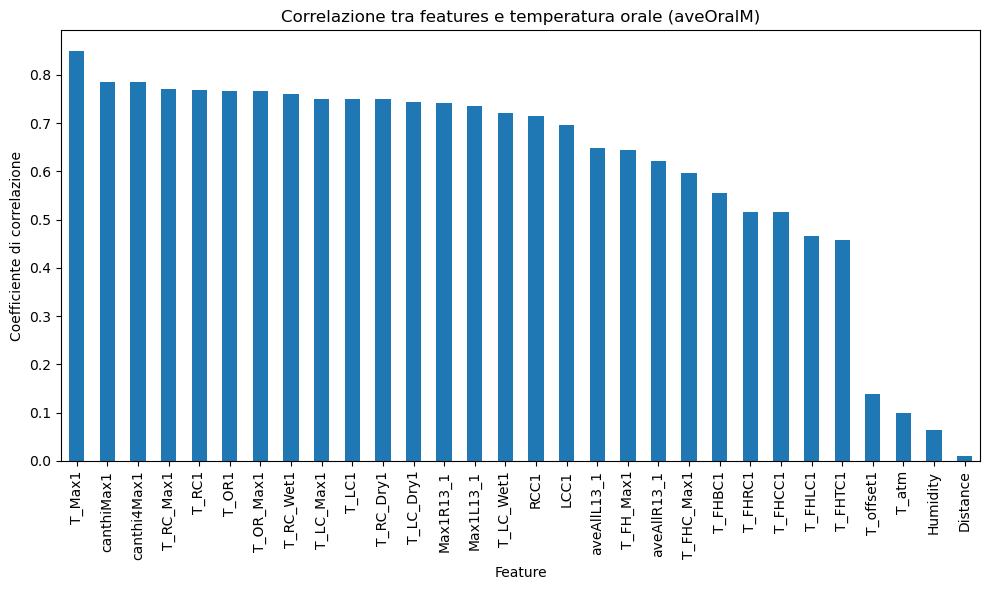

In [9]:
TARGET_VARIABLE = 'aveOralM'

# Calcola la correlazione tra tutte le feature numeriche e la temperatura orale (aveOralM)
correlations = dataset.corr(numeric_only=True)[TARGET_VARIABLE].drop(['aveOralM', 'aveOralF']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title('Correlazione tra features e temperatura orale (aveOralM)')
plt.ylabel('Coefficiente di correlazione')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

Vediamo che `T_Max1`, ovvero la temperatura massima misurata su tutta la faccia, presenta una forte correlazione con la temperatura misurata nel cavo orale. Come ci aspettiamo, le variabili meno correlate sono quelle che non si riferiscono direttamente alla temperatura del soggetto:
- `T_offset1`: scarto tra una temperatura nota e quella misurata dalla videocamera a infrarossi
- `T_atm`: temperatura ambientale
- `Humidity`: umidità relativa
- `Distance`: distanza del soggetto dalla videocamera a infrarossi

Visualizziamo attraverso una matrice di correlazione quali sono le feature maggiormente ridondanti:

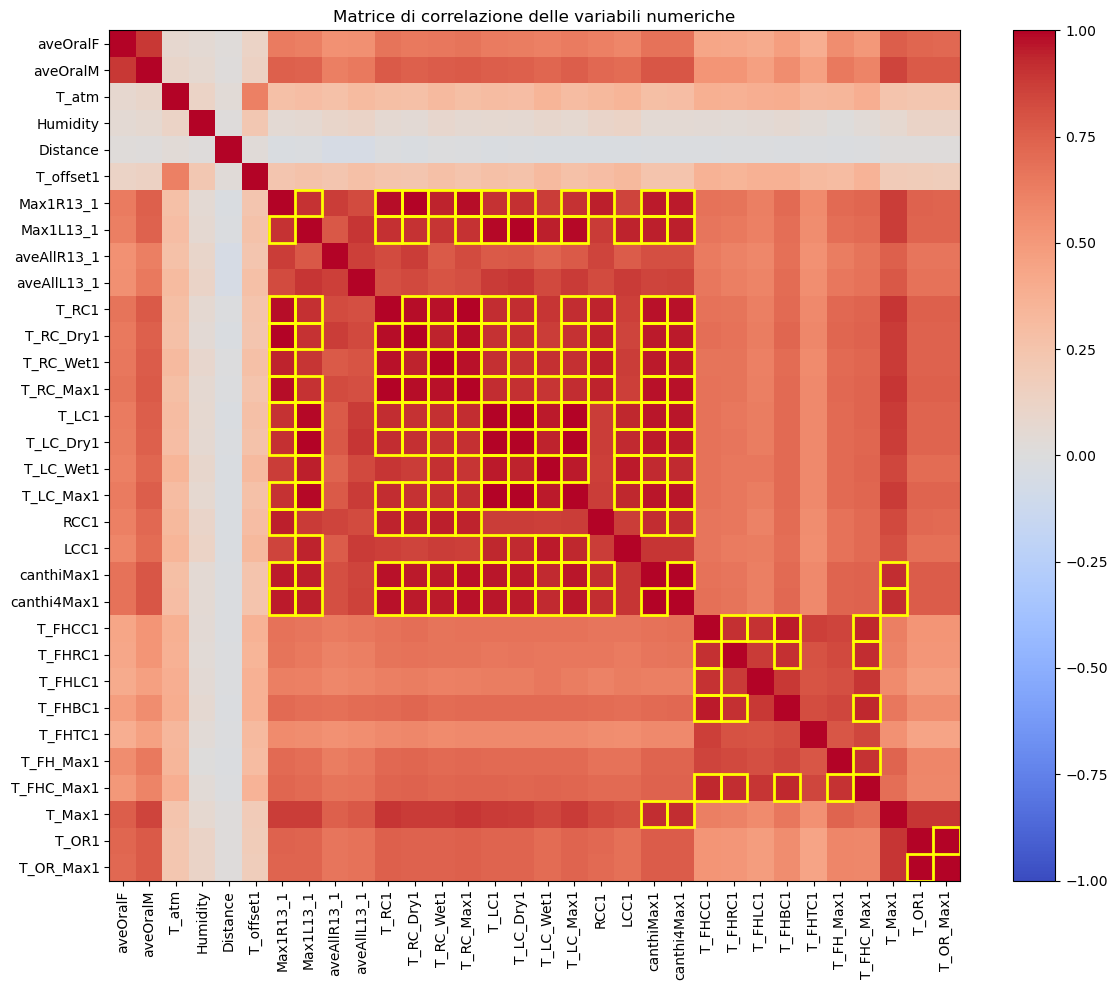

In [10]:
# Valore oltre il quale consideriamo una correlazione troppo alta
CORRELATION_THRESHOLD = 0.90

# Calcoliamo la matrice di correlazione tra tutte le variabili numeriche del dataset
corr_matrix = dataset.corr(numeric_only=True)

# Troviamo le coppie di variabili con correlazione assoluta > 0.9 (escludendo la diagonale)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > CORRELATION_THRESHOLD:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

# Visualizziamo la matrice di correlazione come heatmap
plt.figure(figsize=(14, 10))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Matrice di correlazione delle variabili numeriche')

# Evidenziamo le celle con correlazione > 0.9
for var1, var2, corr_val in high_corr:
    i = corr_matrix.columns.get_loc(var1)
    j = corr_matrix.columns.get_loc(var2)
    plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='yellow', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='yellow', linewidth=2))

plt.tight_layout()
plt.show()

Possiamo vedere come molte delle variabili siano altamente collineari. Ci aspettiamo che questo produca instabilità nei modelli lineari, che andrà affrontata effettuando regolarizzazioni o selezioni delle feature più importanti.

Attraverso un box plot, andiamo a visualizzare le caratteristiche statistiche delle varie feature, ordinate per grado di correlazione con `aveOralM`:

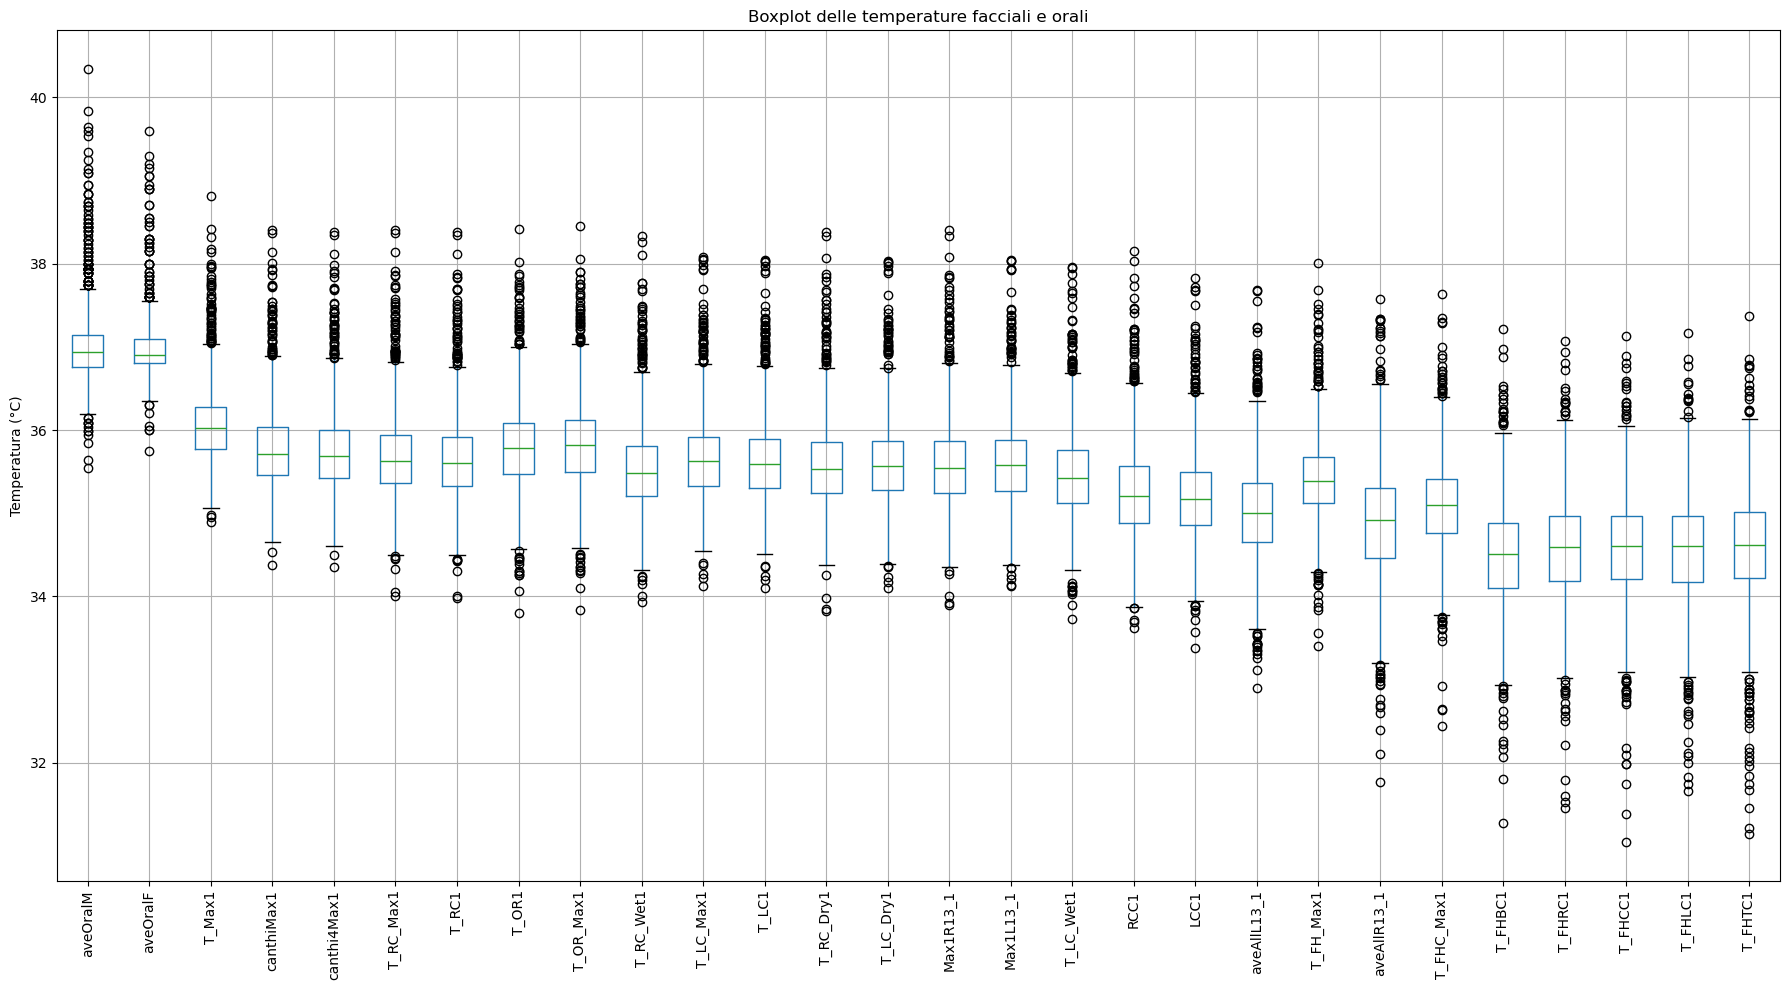

In [11]:
# Lista delle variabili di input che si rifersicono alla temperatura facciale del soggetto
temperature_features = [
    "Max1R13_1",
    "Max1L13_1",
    "aveAllR13_1",
    "aveAllL13_1",
    "T_RC1",
    "T_RC_Dry1",
    "T_RC_Wet1",
    "T_RC_Max1",
    "T_LC1",
    "T_LC_Dry1",
    "T_LC_Wet1",
    "T_LC_Max1",
    "RCC1",
    "LCC1",
    "canthiMax1",
    "canthi4Max1",
    "T_FHCC1",
    "T_FHRC1",
    "T_FHLC1",
    "T_FHBC1",
    "T_FHTC1",
    "T_FH_Max1",
    "T_FHC_Max1",
    "T_Max1",
    "T_OR1",
    "T_OR_Max1"
]

plt.figure(figsize=(18, 10))
# Prendiamo l'ordine delle features da correlations, escludendo quelle che non sono temperature facciali
ordered_temp_features = [feat for feat in correlations.index if feat in temperature_features]
boxplot_features = ['aveOralM', 'aveOralF'] + ordered_temp_features
dataset[boxplot_features].boxplot(rot=90)
plt.title('Boxplot delle temperature facciali e orali')
plt.ylabel('Temperatura (°C)')
plt.tight_layout()
plt.show()

Vediamo che le temperature misurate sulla fronte (`T_FH...`) sono poco correlate con quella orale e mediamente più basse rispetto alle altre aree del viso. Le temperature che risultano più interessanti sono invece quelle prese dall'area estesa dei canthi oculari (vedere immagine esplicativa), e quelle prese dalla regione delle labbra (`T_OR...`).

## Analisi delle variabili categoriche

Analizziamo più nel dettaglio le informazioni demografiche che abbiamo sui soggetti:

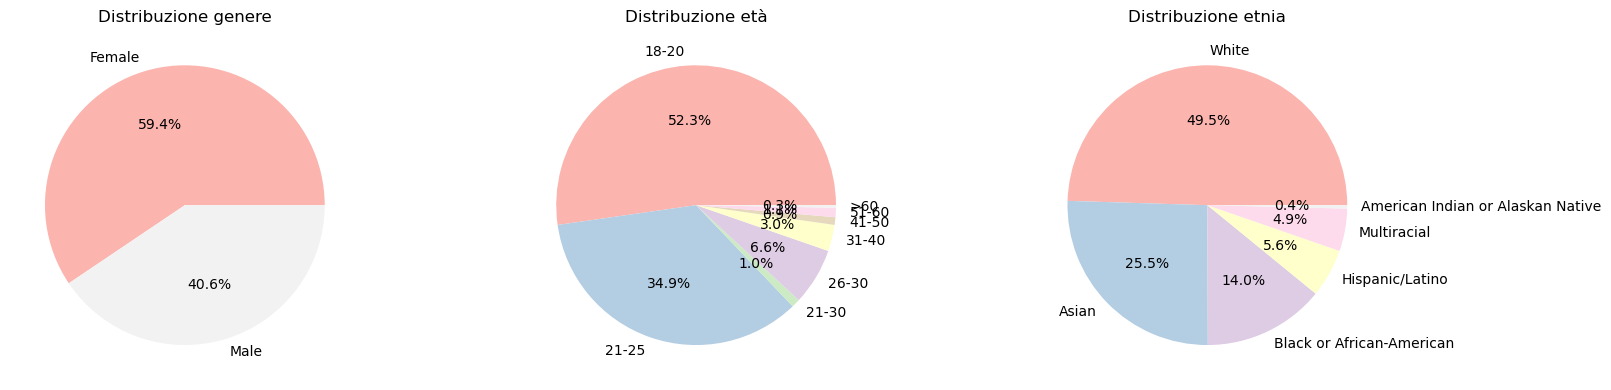

In [12]:
COLORMAP = 'Pastel1'
FORMAT = '%1.1f%%'

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

dataset['Gender'].value_counts().plot(kind='pie', ax=axs[0], autopct=FORMAT, colormap=COLORMAP)
axs[0].set_ylabel('')
axs[0].set_title('Distribuzione genere')

dataset['Age'].value_counts().sort_index().plot(kind='pie', ax=axs[1], autopct=FORMAT, colormap=COLORMAP)
axs[1].set_ylabel('')
axs[1].set_title('Distribuzione età')

dataset['Ethnicity'].value_counts().plot(kind='pie', ax=axs[2], autopct=FORMAT, colormap=COLORMAP)
axs[2].set_ylabel('')
axs[2].set_title('Distribuzione etnia')

plt.tight_layout()
plt.show()

Vediamo che il dataset è leggermente sbilanciato in favore di pazienti di sesso femminile; inoltre, più dell'80% dei dati si riferiscono ad individui con meno di 25 anni e la metà delle istanze è stata rilevata su pazienti di etnia caucasica. 

Potrebbe essere interessante verificare quanto questa distribuzione sbilanciata possa portare i modelli addestrati a comportarsi "peggio" su individui delle categorie meno rappresentate.

Una domanda a cui possiamo rispondere subito, però, è se esistano differenze statisticamente osservabili tra i vari gruppi.

### Differenza tra maschi e femmine

Confrontiamo la temperatura orale media tra maschi e femmine utilizzando un t-test di Student per campioni indipendenti, andando a verificare se esista una differenza statisticamente significativa tra le medie dei due gruppi.

C:\Users\david\AppData\Local\Temp\ipykernel_7072\2238322026.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([oral_temp_female, oral_temp_male], labels=['Femmine', 'Maschi'])


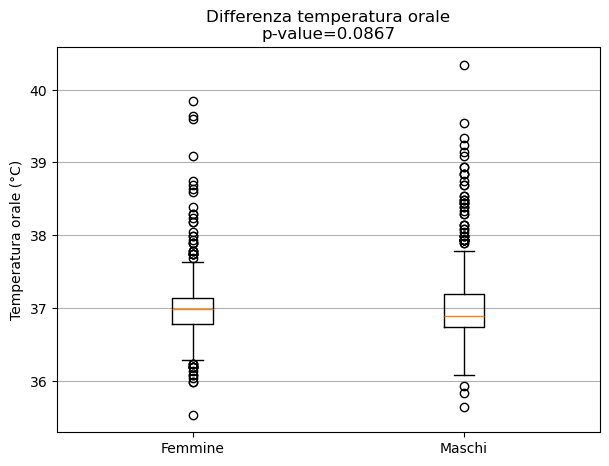

In [13]:
# Estraiamo le temperature orali per maschi e femmine
oral_temp_female = dataset.loc[dataset['Gender'] == 'Female', TARGET_VARIABLE]
oral_temp_male = dataset.loc[dataset['Gender'] == 'Male', TARGET_VARIABLE]

# t-test
t_stat, p_value = scipy.stats.ttest_ind(oral_temp_female, oral_temp_male, equal_var=False)

# Visualizzazione boxplot
plt.figure(figsize=(7,5))
plt.boxplot([oral_temp_female, oral_temp_male], labels=['Femmine', 'Maschi'])
plt.ylabel('Temperatura orale (°C)')
plt.title(f'Differenza temperatura orale\np-value={p_value:.4f}')
plt.grid(axis='y')
plt.show()

Il risultato ottenuto, p-value = 0.0867 non permette di affermare una differenza statisticamente significativa tra i due gruppi alla soglia di confidenza comunemente adottata (0.05). Tuttavia, il valore è vicino alla soglia, suggerendo che potrebbe esserci una tendenza verso una differenza, ma non abbastanza forte da essere confermata con i dati a disposizione.

## Sesso ed etnia

Quando le categorie da confrontare sono più di due (come per etnia o fasce d'età), il t-test non è più adatto: dovremmo infatti effettuare molteplici confronti a coppie, aumentando il rischio di ottenere risultati falsi positivi.

In questi casi si utilizza il test ANOVA (Analysis of Variance), che permette di verificare se esistono differenze statisticamente significative tra le medie di più di due gruppi contemporaneamente.

<Figure size 800x500 with 0 Axes>

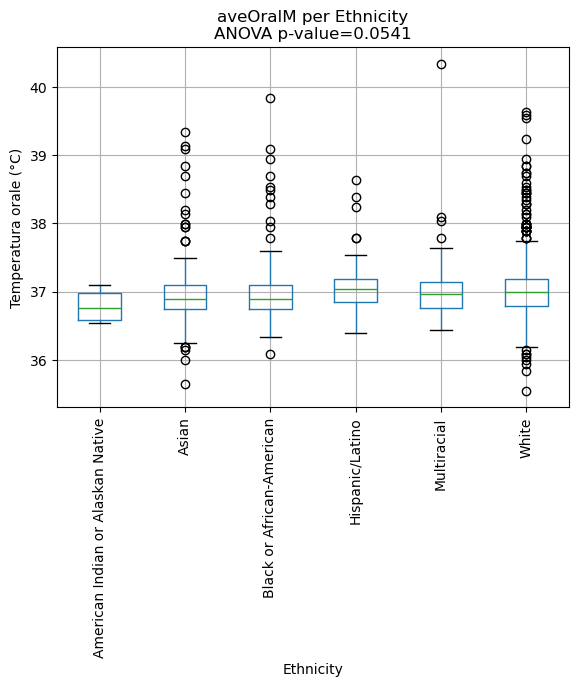

p-value ANOVA per Ethnicity: 0.0541


<Figure size 800x500 with 0 Axes>

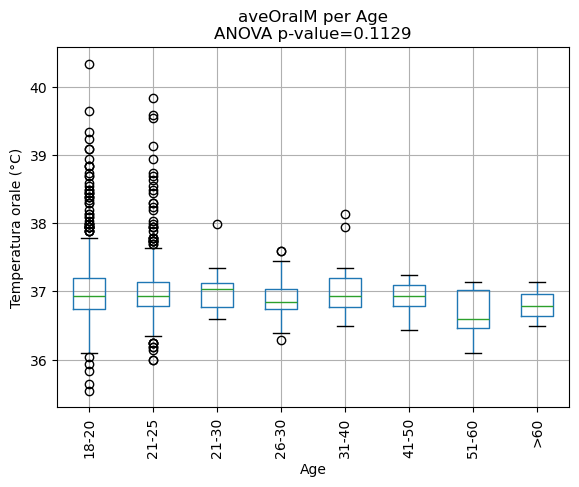

p-value ANOVA per Age: 0.1129


In [14]:
# Funzione per test ANOVA e visualizzazione boxplot per una variabile categoriale
def test_group_difference(column, target=TARGET_VARIABLE):
    groups = [group[target].values for name, group in dataset.groupby(column, observed=True)]
    f_stat, p_val = scipy.stats.f_oneway(*groups)
    plt.figure(figsize=(8,5))
    dataset.boxplot(column=target, by=column)
    plt.xticks(rotation=90)
    plt.title(f'{target} per {column}\nANOVA p-value={p_val:.4f}')
    plt.suptitle('')
    plt.ylabel('Temperatura orale (°C)')
    plt.show()
    print(f"p-value ANOVA per {column}: {p_val:.4f}")

# Test per etnia
test_group_difference('Ethnicity', target=TARGET_VARIABLE)

# Test per fasce d'età
test_group_difference('Age', target=TARGET_VARIABLE)

I risultati dei test ANOVA mostrano che:

- **Per l'etnia**, il p-value è 0.0541, leggermente superiore alla soglia convenzionale di 0.05. Questo indica che non ci sono differenze statisticamente significative tra le medie delle temperature orali nei diversi gruppi etnici, anche se il risultato è vicino alla significatività.
- **Per le fasce d'età**, il p-value è 0.1129, ben al di sopra della soglia di 0.05. Anche in questo caso, non si osservano differenze statisticamente significative tra le medie delle temperature orali nei diversi gruppi di età.

In sintesi, non emergono differenze significative nemmeno tra i gruppi di etnia e di età rispetto alla temperatura orale media.

## Impatto dei fattori demografici sulla correlazione

I risultati ottenuti, tuttavia, non sono conclusivi nel determinare l'utilità o meno del mantenimento delle features demografiche, in quanto anche se l'appartenenza a diversi gruppi non comporta una temperatura corporea statisticament diversa, potrebbe comunque comportare un diverso grado di correlazione tra la temperatura facciale e quella orale.  

Come indice rappresentativo scegliamo la variabile con la correlazione più alta rispetto alla temperatura orale, ovvero `T_Max1` (la massima temperatura rilevata sul volto). Questo ci permette di indagare se la relazione tra temperatura facciale e temperatura orale sia costante nei diversi gruppi demografici, oppure se esistano differenze significative che potrebbero giustificare l’inclusione delle variabili demografiche nei modelli predittivi. In altre parole, se la correlazione tra `T_Max1` e `aveOralM` cambia sensibilmente tra gruppi (ad esempio tra etnie o fasce d’età), possiamo concludere che le informazioni demografiche sembrino essere rilevanti per migliorare la previsione della temperatura orale.

Per confrontare le correlazioni tra gruppi diversi, utilizziamo la trasformazione di Fisher r-to-z:

$$
  z = \frac{1}{2} \ln\left(\frac{1 + r}{1 - r}\right)
$$

La trasformazione di Fisher converte i coefficienti di correlazione ($r$) in valori $z$, che sono approssimativamente distribuiti normalmente e quindi confrontabili tra loro. Per ogni coppia di gruppi, calcoliamo il rapporto tra la differenza tra i valori $z$ e il relativo errore standard ($SE$), ottenendo uno z-score che misura quanto la differenza tra le correlazioni sia significativa. 

$$
  z_{stat} = \frac{z_1 - z_2}{SE}
  $$

$$
  SE = \sqrt{\frac{1}{n_1 - 3} + \frac{1}{n_2 - 3}}
$$
  Dove $n_1$ e $n_2$ sono le dimensioni dei due gruppi.


Dal valore $z$ otteniamo il p-value, che indica la probabilità che la differenza osservata sia dovuta al caso. Se almeno una coppia di gruppi mostra una differenza statisticamente significativa ($p < 0.05$), possiamo dedurre che il gruppo demografico influenza la relazione tra le due variabili con buona probabilità.

In [15]:
def analyze_group_correlation(group_col):
    # Usiamo la variabile più correlata con aveOralM (T_Max1)
    top_corr_var = correlations.idxmax()

    # Calcoliamo la correlazione tra top_corr_var e aveOralM per ciascun gruppo
    group_corrs = dataset.groupby(group_col, observed=True).apply(lambda g: g[top_corr_var].corr(g['aveOralM']), include_groups=False)
    n = dataset.groupby(group_col, observed=True).size()

    # Disegnamo il grafico delle correlazioni per gruppo
    plt.figure(figsize=(8,5))
    group_corrs.sort_values().plot(kind='bar', color='skyblue')
    plt.ylabel('Coefficiente di correlazione')
    plt.title(f'Correlazione tra {top_corr_var} e aveOralM per {group_col}')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Riportiamo una sintesi tabellare con le correlazioni e il numero di soggetti per gruppo
    summary = group_corrs.round(2).to_frame('Correlazione')
    summary['N soggetti'] = n
    display(summary)

    # Test statistico: confronto tra coefficienti di correlazione (Fisher r-to-z)
    def fisher_z(r):
        r = np.clip(r, -0.9999, 0.9999) # La trasformazione Fisher è definita per r in (-1, 1)
        return 0.5 * np.log((1 + r) / (1 - r))

    zs = group_corrs.apply(fisher_z)
    significant = False
    for (g1, g2) in combinations(group_corrs.index, 2):
        n1, n2 = n[g1], n[g2]
        if n1 <= 3 or n2 <= 3:
            continue  # Troppo pochi dati per confronto affidabile
        z1, z2 = zs[g1], zs[g2]
        se = np.sqrt(1/(n1-3) + 1/(n2-3))
        if se == 0 or np.isnan(se):
            continue
        z_stat = (z1 - z2) / se
        p_val = 2 * (1 - scipy.stats.norm.cdf(abs(z_stat)))
        if p_val < 0.05:
            significant = True
            break

    if significant:
        print("⚠️ Esistono differenze statisticamente significative tra le correlazioni dei gruppi.")
    else:
        print("Non ci sono differenze statisticamente significative tra le correlazioni dei gruppi.")

### Sesso

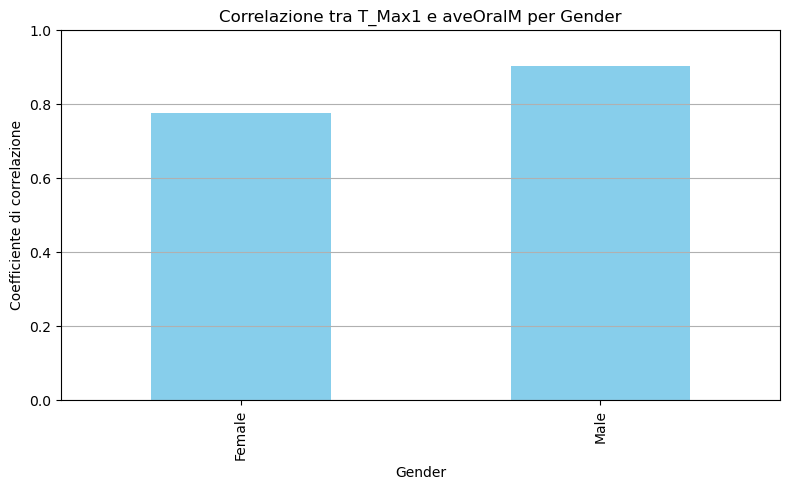

,Correlazione,N soggetti
Gender,,
Female,0.78,605
Male,0.90,413


⚠️ Esistono differenze statisticamente significative tra le correlazioni dei gruppi.


In [16]:
analyze_group_correlation('Gender')

### Età

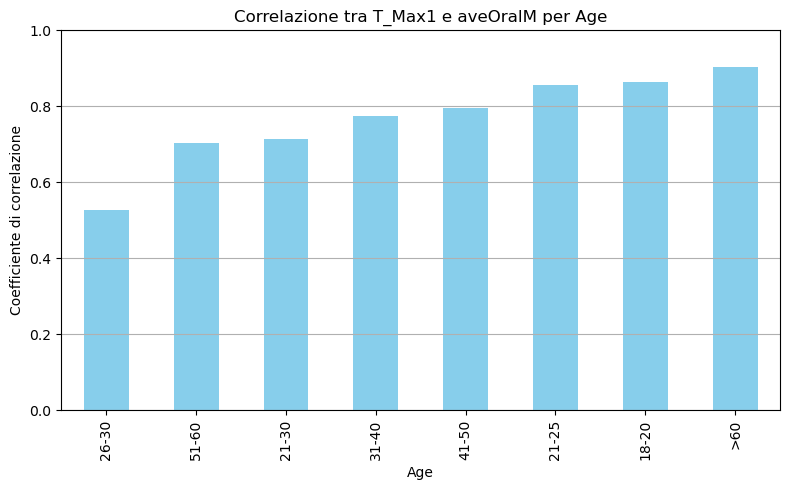

,Correlazione,N soggetti
Age,,
18-20,0.86,532
21-25,0.86,355
21-30,0.72,10
26-30,0.53,67
31-40,0.77,31
41-50,0.80,9
51-60,0.70,11
>60,0.90,3


⚠️ Esistono differenze statisticamente significative tra le correlazioni dei gruppi.


In [17]:
analyze_group_correlation('Age')

### Etnia

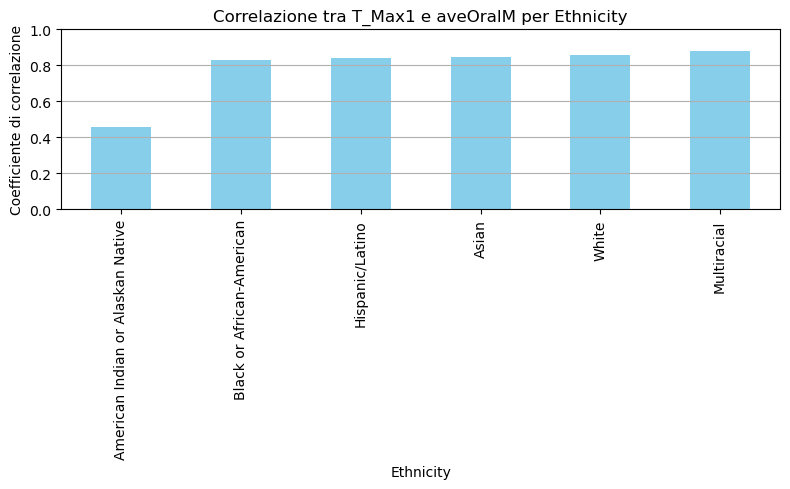

,Correlazione,N soggetti
Ethnicity,,
American Indian or Alaskan Native,0.46,4
Asian,0.85,260
Black or African-American,0.83,143
Hispanic/Latino,0.84,57
Multiracial,0.88,50
White,0.86,504


Non ci sono differenze statisticamente significative tra le correlazioni dei gruppi.


In [18]:
analyze_group_correlation('Ethnicity')

La correlazione per il gruppo "American Indian or Alaskan Native" è bassa (0.46), ma il test di significatività tra correlazioni (Fisher r-to-z) tiene conto anche della numerosità dei gruppi. In questo caso, il gruppo ha solo 4 soggetti: un campione così piccolo rende la stima della correlazione molto instabile e l’incertezza (errore standard) molto alta. 

Quando si confrontano le correlazioni tra gruppi, il test statistico verifica se la differenza osservata è maggiore di quanto ci si aspetterebbe per caso, considerando la variabilità dovuta alla dimensione del campione. Con pochi dati, anche differenze apparentemente grandi possono non risultare statisticamente significative, perché non si può escludere che siano dovute al caso. Quindi, la bassa correlazione osservata in quel gruppo non è statisticamente diversa da quella degli altri gruppi, principalmente a causa della numerosità molto ridotta.

### Conclusione

In base ai risultati ottenuti, analizziamo l'utilità delle features riguardanti la demografica degli individui.

**Sesso:**
- La temperatura orale media non differisce in modo statisticamente significativo tra maschi e femmine.
- Tuttavia, la correlazione tra temperatura facciale massima e orale è significativamente diversa tra i sessi.

**Conclusione:** Il sesso è con buona probabilità una feature utile e dovrebbe essere mantenuta nel modello di regressione.

**Età:**
- Non ci sono differenze significative nella temperatura orale media tra le fasce d’età.
- Tuttavia, la correlazione tra temperatura facciale massima e orale varia significativamente tra le fasce d’età.

**Conclusione:** L’età sembra essere utile per migliorare la capacità predittiva del modello e dovrebbe essere considerata.

**Etnia:**
- Non ci sono differenze significative nella temperatura orale media tra i gruppi etnici.
- Non ci sono differenze significative nella correlazione tra temperatura facciale massima e orale tra le etnie.

**Conclusione:** L’etnia non sembra apportare un contributo significativo al modello di regressione e può essere esclusa.

Procediamo quindi ad eliminare l'etnia dal dataset.

In [19]:
dataset = dataset.drop('Ethnicity', axis=1)

# Addestramento di modelli

## Preparazione dei dati per il training

Estraiamo dal dataset la matrice degli input e il vettore degli output attesi. Procediamo quindi a dividerli in un set di training e uno di validazione, secondo il metodo hold-out.

In [20]:
X, y = dataset.drop(['aveOralM', 'aveOralF'], axis=1), dataset['aveOralM']

# Lista delle colonne categoriali
categorical_columns = X.select_dtypes(include='category').columns.tolist()

# Lista dei valori per ogni colonna categoriale, da fornire a OneHotEncoder per evitare che categorie non presenti nel training causino errori
categorical_values = [X[cat].cat.categories.tolist() for cat in categorical_columns]

# Lista delle colonne numeriche
numerical_columns = X.select_dtypes(exclude='category').columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Funzioni per la valutazione dei modelli

La funzione `evaluate_regression_model` valuta le prestazioni di un modello di regressione calcolando diversi indicatori di errore e qualità del fit:

- **R² (coefficiente di determinazione):** misura la proporzione di varianza della variabile target spiegata dal modello. Tuttavia, tende ad avvantaggiare modelli che fanno uso di molte features.
- **R² aggiustato:** a differenza di R², penalizza l’aggiunta di variabili non informative, tenendo conto del numero di feature rispetto al numero di osservazioni. È particolarmente nel nostro caso, in quanto confronteremo modelli con numeri diversi di variabili.
- **RMSE (Root Mean Squared Error):** radice quadrata dell’errore quadratico medio.
- **MAE (Mean Absolute Error):** errore assoluto medio.

La funzione inoltre visualizza un grafico dei **residui** (differenza tra valore osservato e predetto) rispetto alle predizioni. Analizzare la distribuzione dei residui può essere utile a valutare un modello: residui distribuiti casualmente attorno allo zero suggeriscono che il modello è appropriato, mentre pattern evidenti possono indicare problemi.


In [21]:
def evaluate_regression_model(model, X_val, y_val, print_results=True):
    """
    Valuta un modello di regressione su un set di validazione.
    Stampa e restituisce R^2, R^2 aggiustato, RMSE, MAE e visualizza i residui.
    """
    y_pred = model.predict(X_val)
    n = len(y_val)

    try:
        # Numero di feature con peso diverso da zero
        coefs = model.named_steps['regressor'].coef_
        p = np.sum(coefs != 0)
    except AttributeError:
        # Se il modello non è un modello lineare, non possiamo calcolare i coefficienti direttamente
        if print_results:
            print("Impossibile determinare il numero di feature con peso diverso da zero.\nAssumiamo che tutte le feature siano utilizzate.")
        p = len(X_val.columns)  

    r2 = r2_score(y_val, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    if print_results:
        print(f"R^2: {r2:.4f}")
        print(f"R^2 aggiustato: {adj_r2:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")

        # Visualizziamo i residui
        residuals = y_val - y_pred
        plt.figure(figsize=(8, 5))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predizione')
        plt.ylabel('Residuo')
        plt.title('Residui vs Predizione')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Restituiamo le metriche per il confronto finale
    return {
        "r2": r2,
        "adj_r2": adj_r2,
        "rmse": rmse,
        "mae": mae,
        "mape": mape
    }

La funzione `plot_feature_weights` estrae e visualizza i pesi (coefficenti) assegnati alle feature da una pipeline sklearn con il formato che adotteremo per tutti i nostri modelli (soltanto due step "principali", `preprocessor` e `regressor`). In particolare:

- Recupera i nomi delle feature trasformate dal preprocessor e i relativi pesi dal regressore.
- Filtra e mostra solo le feature con peso diverso da zero (cioè quelle effettivamente utilizzate dal modello).
- Opzionalmente, può escludere la feature di intercetta ("1") dal grafico.
- Ordina le feature per peso (in valore assoluto) e visualizza un grafico a barre che mostra quanto ogni feature contribuisce alla predizione del modello.

Questo permette di visualizzare quali variabili hanno maggiore impatto sulla previsione e in che direzione (positiva o negativa).

In [22]:
def plot_feature_weights(model, exclude_intercept=False):
    """
    Estrae e visualizza i pesi delle feature da un modello sklearn Pipeline con preprocessor e regressor lineare.
    Se exclude_intercept=True, esclude la feature '1' (intercetta) dal grafico.
    """
    regressor = model.named_steps['regressor']
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    coefs = regressor.coef_

    # Filtra solo le feature con peso diverso da zero
    mask = coefs != 0
    filtered_features = [f for f, m in zip(feature_names, mask) if m]
    filtered_coefs = coefs[mask]

    # Escludi la feature '1' se richiesto
    if exclude_intercept:
        filtered = [(f, c) for f, c in zip(filtered_features, filtered_coefs) if f != '1']
        if filtered:
            filtered_features, filtered_coefs = zip(*filtered)
        else:
            filtered_features, filtered_coefs = [], []

    if len(filtered_features) == 0:
        print("Nessuna feature con peso diverso da zero.")
        return
    
    weights_df = pd.DataFrame({'Feature': filtered_features, 'Weight': filtered_coefs})
    weights_df = weights_df.sort_values('Weight', key=abs, ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(weights_df['Feature'], weights_df['Weight'])
    plt.xticks(rotation=90)
    plt.title('Pesi assegnati alle feature dal modello')
    plt.ylabel('Peso')
    plt.tight_layout()
    plt.show()

## Punto di partenza

Cominciamo "buttando il cuore oltre all'ostacolo", ovvero proviamo ad addestrare il modello più semplice di tutti e vediamo come si comporta, anche se possiamo già prevedere che sarà soggetto a forte instabilità. 

Questo, tuttavia, ci fornirà un'ottima baseline contro cui paragonare le soluzioni successive.

In [23]:
base_preprocessor = ColumnTransformer(
    transformers = [
        # Standardizziamo le colonne numeriche, in quanto alcune fanno riferimento a granddezze diverse, con scala molto diversa
        (NUM, StandardScaler(), numerical_columns),

        # Codifichiamo le colonne categoriali con OneHotEncoder, specificando le categorie per evitare errori in fase di predizione
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ]
)

base_model = Pipeline([
    ('preprocessor', base_preprocessor),
    ('regressor', LinearRegression())
])

base_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['T_atm', 'Humidity',
                                                   'Distance', 'T_offset1',
                                                   'Max1R13_1', 'Max1L13_1',
                                                   'aveAllR13_1', 'aveAllL13_1',
                                                   'T_RC1', 'T_RC_Dry1',
                                                   'T_RC_Wet1', 'T_RC_Max1',
                                                   'T_LC1', 'T_LC_Dry1',
                                                   'T_LC_Wet1', 'T_LC_Max1',
                                                   'RCC1', 'LCC1', 'canthiMax1',
                                                   'canthi4Max1', 'T_FHCC1',
                                                   'T_FHRC1', 'T_FHLC1',
                                                   'T_FHBC1', 'T_FHTC1',
                                                   'T_FH_Max1', 'T_FHC_Max1',
                                                   'T_Max1', 'T_OR1',
                                                   'T_OR_Max1']),
                                                 ('categorical',
                                                  OneHotEncoder(categories=[['Female',
                                                                             'Male'],
                                                                            ['18-20',
                                                                             '21-25',
                                                                             '21-30',
                                                                             '26-30',
                                                                             '31-40',
                                                                             '41-50',
                                                                             '51-60',
                                                                             '>60']],
                                                                drop='first'),
                                                  ['Gender', 'Age'])])),
                ('regressor', LinearRegression())])

R^2: 0.6621
R^2 aggiustato: 0.5843
RMSE: 0.2592
MAE: 0.2018
MAPE: 0.54%


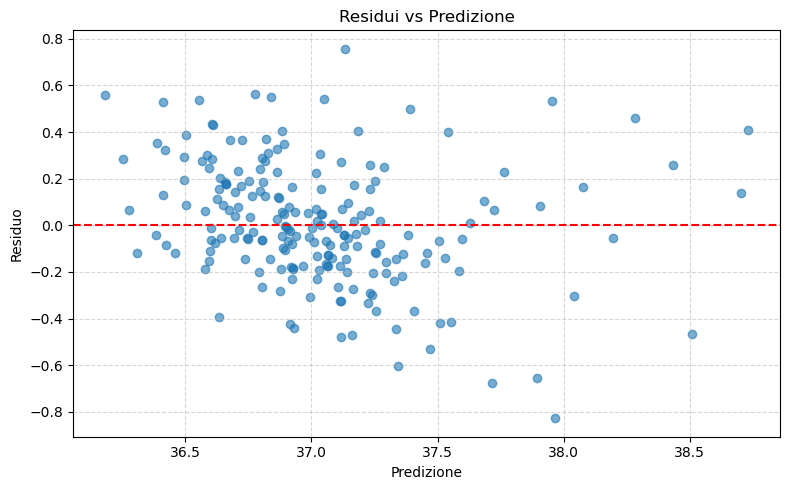

In [24]:
# Creiamo un dizionario per memorizzare i risultati delle valutazioni dei modelli
results = {}

results['base_model'] = evaluate_regression_model(base_model, X_val, y_val)

Il risultato fornito da un approccio così semplice non è terribile, ma può sicuramente essere migliorato. Vediamo i pesi che ha assegnato alle diverse feature:

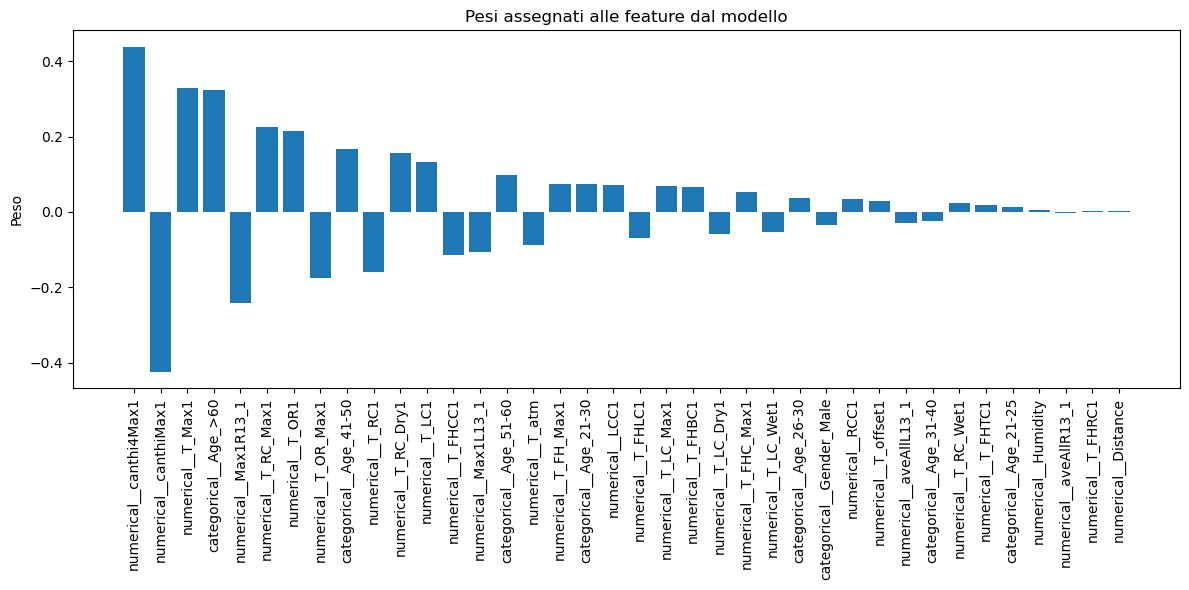

In [25]:
plot_feature_weights(base_model)

Come ci aspettavamo, il modello ha assegnato pesi instabili, dando a feature che rappresentano misure molto simili pesi opposti.

Ad esempio `canthi4Max1` e `canthiMax1` hanno pesi sostanzialmente uguali in valore assoluto ma opposti; tuttavia, queste features misurano quasi la stessa cosa. 

Questo comportamento è tipico dei modelli di regressione lineare in presenza di **multicollinearità**. In questi casi, il modello può assegnare pesi di segno opposto e di grande valore assoluto a feature simili, pur mantenendo una buona accuratezza complessiva. Vediamo quindi cosa possiamo fare per risolvere il problema.

## Combattere la collinearità

Per affrontare il problema della collinearità tra le numerose variabili nel task di regressione (predizione della temperatura orale), proponiamo tre approcci:

1. Selezione automatica delle feature più rilevanti attraverso regressione lineare regolarizzata (Lasso, Ridge, ElasticNet)

2. Regressione con analisi delle componenti principali (PCA)

3. Utilizzo di modelli non lineari basati su alberi (XGBoost)

## 1 - Regressione lineare regolarizzata

### Regolarizzazione L2 (Ridge)

In [26]:
ridge_preprocessor = ColumnTransformer(
    transformers = [
        (NUM, StandardScaler(), numerical_columns),
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ] 
)

ridge_model = Pipeline([
    ('preprocessor', ridge_preprocessor),
    ('regressor', Ridge(fit_intercept=True)),
])

ridge_grid = {
    'regressor__alpha': np.logspace(-4, 2, 30)
}

kf_5 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

ridge_grid_search = GridSearchCV(
    ridge_model,
    ridge_grid,
    cv = kf_5,
    n_jobs=-1
)

ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['T_atm',
                                                                          'Humidity',
                                                                          'Distance',
                                                                          'T_offset1',
                                                                          'Max1R13_1',
                                                                          'Max1L13_1',
                                                                          'aveAllR13_1',
                                                                          'aveAllL13_1',
                                                                          'T_RC1',
                                                                          'T_RC_Dry1',
                                                                          'T_RC_Wet1',
                                                                          'T_RC_Max1',
                                                                          'T_LC1',
                                                                          'T_LC_Dry1',
                                                                          'T_LC_Wet1',
                                                                          'T_LC_Max1',...
       6.72335754e-04, 1.08263673e-03, 1.74332882e-03, 2.80721620e-03,
       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,
       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,
       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,
       1.37382380e+00, 2.21221629e+00, 3.56224789e+00, 5.73615251e+00,
       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,
       6.21016942e+01, 1.00000000e+02])})

R^2: 0.6778
R^2 aggiustato: 0.6036
RMSE: 0.2532
MAE: 0.1964
MAPE: 0.53%


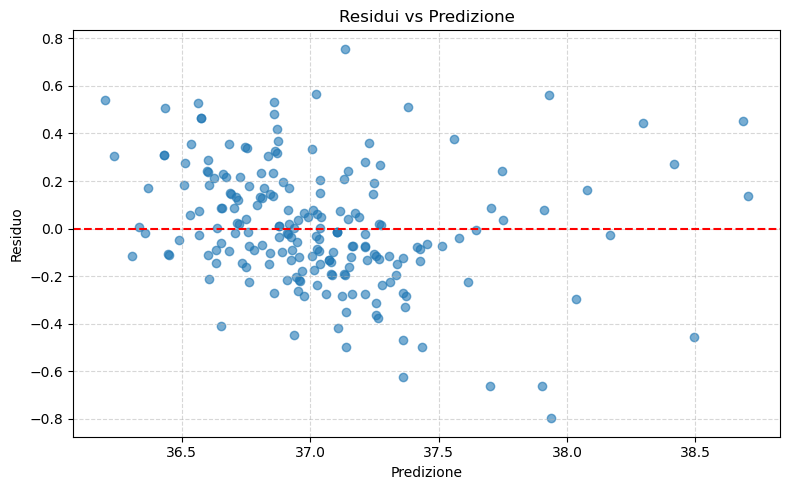

In [27]:
results['ridge_model'] = evaluate_regression_model(ridge_grid_search.best_estimator_, X_val, y_val)

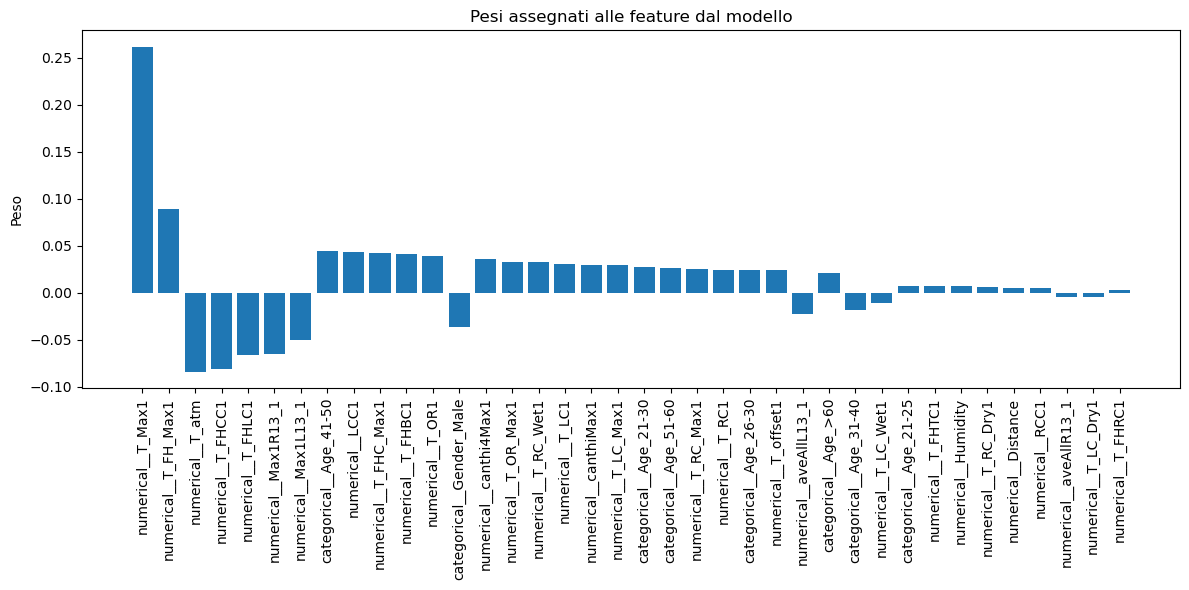

In [28]:
plot_feature_weights(ridge_grid_search.best_estimator_)

Rispetto al modello base, si osserva già un miglioramento: i pesi assegnati alle feature dalla regressione Ridge risultano più regolari e stabili, con una minore presenza di coefficienti negativi. Questo indica che la regolarizzazione aiuta a ridurre l’instabilità dovuta alla multicollinearità, rendendo il modello più interpretabile e robusto.

### Regolarizzazione L1 (Lasso)

In [29]:
lasso_preprocessor = ColumnTransformer(
    transformers = [
        (NUM, StandardScaler(), numerical_columns),
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ] 
)

lasso_model = Pipeline([
    ('preprocessor', lasso_preprocessor),
    ('regressor', Lasso(fit_intercept=True)),
])

lasso_grid = {
    'regressor__alpha': np.logspace(-4, 2, 30)
}

lasso_grid_search = GridSearchCV(
    lasso_model,
    lasso_grid,
    cv = kf_5,
    n_jobs=-1
)

lasso_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['T_atm',
                                                                          'Humidity',
                                                                          'Distance',
                                                                          'T_offset1',
                                                                          'Max1R13_1',
                                                                          'Max1L13_1',
                                                                          'aveAllR13_1',
                                                                          'aveAllL13_1',
                                                                          'T_RC1',
                                                                          'T_RC_Dry1',
                                                                          'T_RC_Wet1',
                                                                          'T_RC_Max1',
                                                                          'T_LC1',
                                                                          'T_LC_Dry1',
                                                                          'T_LC_Wet1',
                                                                          'T_LC_Max1',...
       6.72335754e-04, 1.08263673e-03, 1.74332882e-03, 2.80721620e-03,
       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,
       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,
       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,
       1.37382380e+00, 2.21221629e+00, 3.56224789e+00, 5.73615251e+00,
       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,
       6.21016942e+01, 1.00000000e+02])})

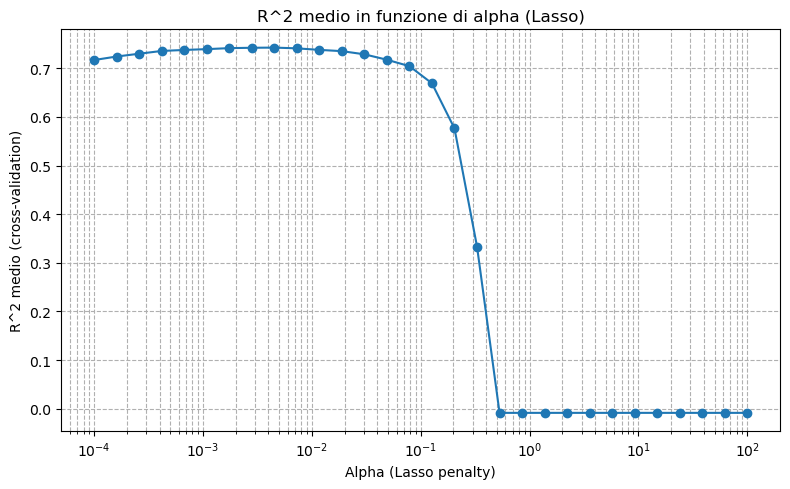

In [30]:
# Mostra un grafico con i valori di alpha e il punteggio medio di cross-validation
results_df = pd.DataFrame(lasso_grid_search.cv_results_)
plt.figure(figsize=(8, 5))
plt.semilogx(results_df['param_regressor__alpha'], results_df['mean_test_score'], marker='o')
plt.xlabel('Alpha (Lasso penalty)')
plt.ylabel('R^2 medio (cross-validation)')
plt.title('R^2 medio in funzione di alpha (Lasso)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

Da questo grafico osserviamo che, aumentando eccessivamente il parametro di regolarizzazione L1 (alpha), le performance del modello Lasso peggiorano sensibilmente. Un valore troppo alto di alpha forza molti coefficienti a zero, riducendo eccessivamente la complessità del modello e portando a una perdita di informazione rilevante per la predizione. È quindi fondamentale selezionare un valore di regolarizzazione che bilanci la riduzione della collinearità senza compromettere la capacità predittiva del modello.

R^2: 0.6749
R^2 aggiustato: 0.6527
RMSE: 0.2543
MAE: 0.1993
MAPE: 0.54%


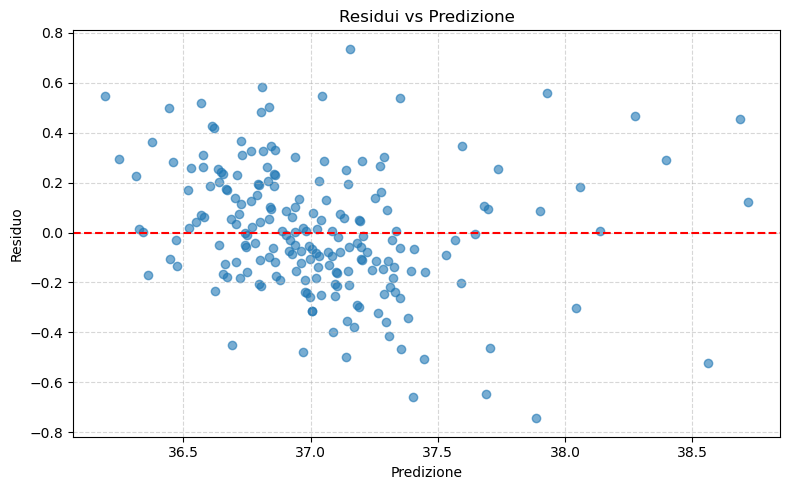

In [31]:
results['lasso_model'] = evaluate_regression_model(lasso_grid_search.best_estimator_, X_val, y_val)

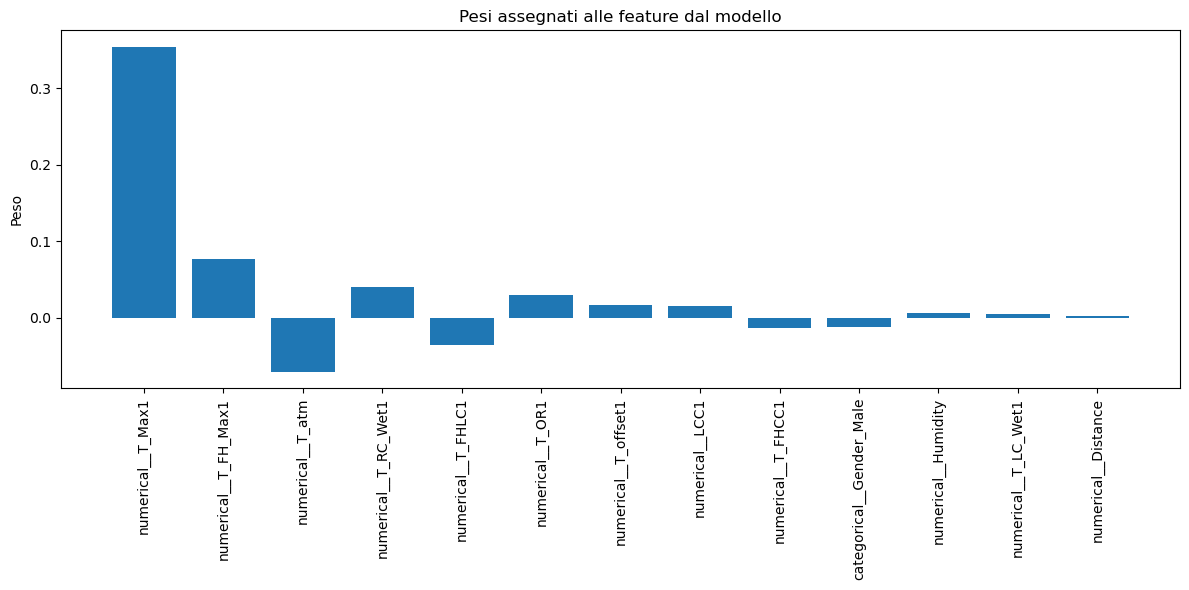

In [32]:
plot_feature_weights(lasso_grid_search.best_estimator_)

Rispetto alla regressione Ridge, questo risultato è nettamente migliore: il modello Lasso utilizza molte meno feature e attribuisce la maggior parte del peso proprio alla variabile che avevamo già identificato come la più correlata con la temperatura orale. Questo conferma l’efficacia della selezione automatica delle feature nel migliorare sia la semplicità che l’interpretabilità del modello.

Una caratteristica interessante, in linea con la conoscenza che abbiamo sul modello è il peso negativo assegnato a `T_atm`: questo ha senso, in quanto una temperatura maggiore dell'aria porta la pelle che vi è esposta ad avere una temperatura maggiore, mentre la termoregolazione del corpo umano impedisce alla temperatura interna di cambiare altrettanto.

### Regolarizzazione L1 + L2 (ElasticNet)

In [33]:
elasticnet_preprocessor = ColumnTransformer(
    transformers = [
        (NUM, StandardScaler(), numerical_columns),
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ] 
)

elasticnet_model = Pipeline([
    ('preprocessor', elasticnet_preprocessor),
    ('regressor', ElasticNet(fit_intercept=True)),
])

elasticnet_grid = {
    "regressor__alpha": np.logspace(-4, 2, 10),
    "regressor__l1_ratio": [0.1, 0.5, 0.9, 0.99, 1.0]
}

elasticnet_grid_search = GridSearchCV(
    elasticnet_model,
    elasticnet_grid,
    cv = kf_5,
    n_jobs=-1
)

elasticnet_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['T_atm',
                                                                          'Humidity',
                                                                          'Distance',
                                                                          'T_offset1',
                                                                          'Max1R13_1',
                                                                          'Max1L13_1',
                                                                          'aveAllR13_1',
                                                                          'aveAllL13_1',
                                                                          'T_RC1',
                                                                          'T_RC_Dry1',
                                                                          'T_RC_Wet1',
                                                                          'T_RC_Max1',
                                                                          'T_LC1',
                                                                          'T_LC_Dry1',
                                                                          'T_LC_Wet1',
                                                                          'T_LC_Max1',...
                                                                                                    '26-30',
                                                                                                    '31-40',
                                                                                                    '41-50',
                                                                                                    '51-60',
                                                                                                    '>60']],
                                                                                       drop='first'),
                                                                         ['Gender',
                                                                          'Age'])])),
                                       ('regressor', ElasticNet())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                         'regressor__l1_ratio': [0.1, 0.5, 0.9, 0.99, 1.0]})

R^2: 0.6787
R^2 aggiustato: 0.6531
RMSE: 0.2528
MAE: 0.1983
MAPE: 0.53%


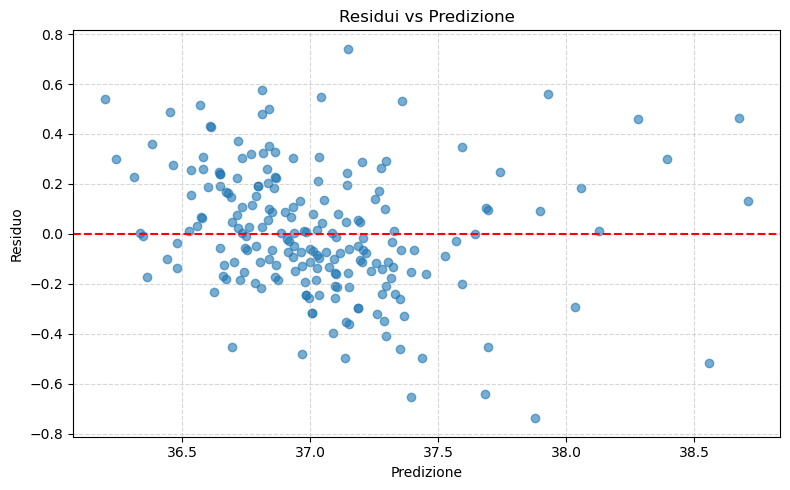

In [34]:
results['elasticnet_model'] = evaluate_regression_model(elasticnet_grid_search.best_estimator_, X_val, y_val)

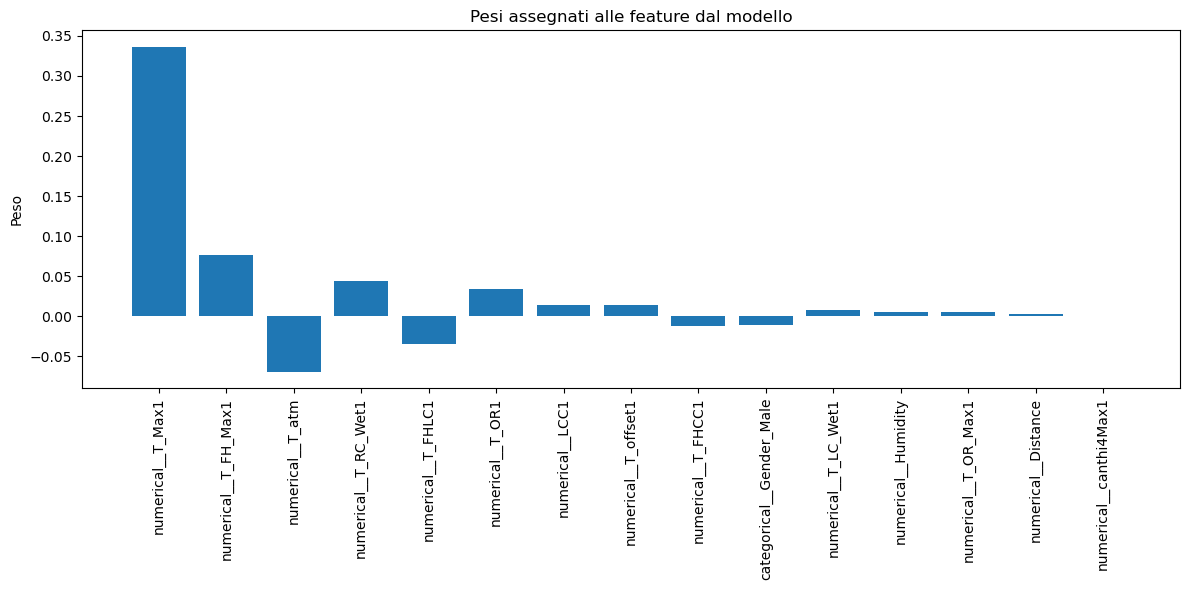

In [35]:
plot_feature_weights(elasticnet_grid_search.best_estimator_)

Il risultato ottenuto con ElasticNet è molto simile a quello ottenuto con Lasso. Questo è prevedibile, in quanto la componente vincente è la regolarizzazione L1 (Lasso), che tende a selezionare poche feature rilevanti, mentre la componente L2 di ElasticNet non aggiunge un contributo sostanziale alla soluzione ottimale.

### Regressione polinomiale su feature selezionate mediante lasso

Il codice sottostante implementa una pipeline più complessa per la regressione, che combina tre tecniche:

1. **Selezione automatica delle feature** tramite Lasso (`SelectFromModel(Lasso())`): seleziona solo le variabili più rilevanti per la predizione, eliminando quelle ridondanti o poco informative.
2. **Espansione polinomiale** (`PolynomialFeatures`): genera nuove feature combinando tra loro le variabili selezionate, permettendo al modello di apprendere relazioni non lineari.
3. **Regolarizzazione ElasticNet**: applica una regressione che combina penalizzazione L1 (Lasso) e L2 (Ridge), migliorando la robustezza e la generalizzazione del modello.

Il tutto viene ottimizzato tramite una ricerca a griglia (`GridSearchCV`) su diversi iperparametri: il grado del polinomio, i parametri di regolarizzazione e il livello di selezione delle feature.

In [36]:
# NOTA: l'acronimo PRLSF sta per Polynomial Regression on Lasso-Selected Features

prlsf_preprocessor = Pipeline([
    ('base_preprocessor', ColumnTransformer(
        transformers=[
            (NUM, StandardScaler(), numerical_columns),
            (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
        ]
    )),
    ('feature_selector', SelectFromModel(Lasso())), 
    ('polynomial_features', PolynomialFeatures(include_bias=True))
])

prlsf_model = Pipeline([
    ('preprocessor', prlsf_preprocessor),
    ('regressor', ElasticNet(fit_intercept=False)) 
])

prlsf_grid = {
    # Valori di feature_selector__estimator__alpha >= 1 non restituiscono nessuna feature, per questo abbiamo alcuni errori nel training
    'preprocessor__feature_selector__estimator__alpha': np.logspace(-4, 2, 10), 
    'preprocessor__polynomial_features__degree': [1, 2, 3],
    'regressor__alpha': np.logspace(-4, 2, 10),
    'regressor__l1_ratio': [0.99, 0.999, 1.0]
}

prlsf_grid_search = GridSearchCV(
    prlsf_model, 
    prlsf_grid, 
    cv=kf_5, 
    n_jobs=-1,
    verbose=2,
)

prlsf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


c:\Users\david\miniconda3\envs\data-intensive\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 4500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\miniconda3\envs\data-intensive\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\david\miniconda3\envs\data-intensive\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\david\miniconda3\envs\data-intens

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('base_preprocessor',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          StandardScaler(),
                                                                                          ['T_atm',
                                                                                           'Humidity',
                                                                                           'Distance',
                                                                                           'T_offset1',
                                                                                           'Max1R13_1',
                                                                                           'Max1L13_1',
                                                                                           'aveAllR13_1',
                                                                                           'aveAllL13_1',
                                                                                           'T_RC1',
                                                                                           'T_RC_Dry1',
                                                                                           'T_RC_Wet1',
                                                                                           'T_RC_Max1',
                                                                                           'T_LC1'...
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                         'preprocessor__polynomial_features__degree': [1, 2, 3],
                         'regressor__alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                         'regressor__l1_ratio': [0.99, 0.999, 1.0]},
             verbose=2)

R^2: 0.7213
R^2 aggiustato: 0.6768
RMSE: 0.2354
MAE: 0.1786
MAPE: 0.48%


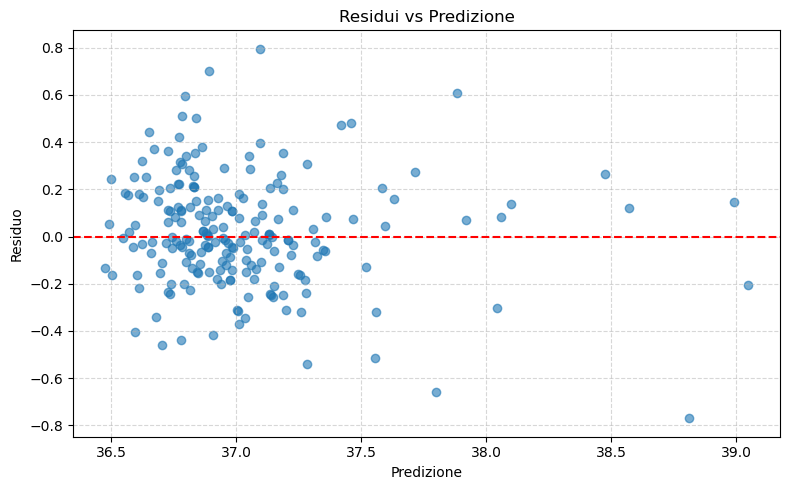

In [37]:
results['prlsf_model'] = evaluate_regression_model(prlsf_grid_search.best_estimator_, X_val, y_val)

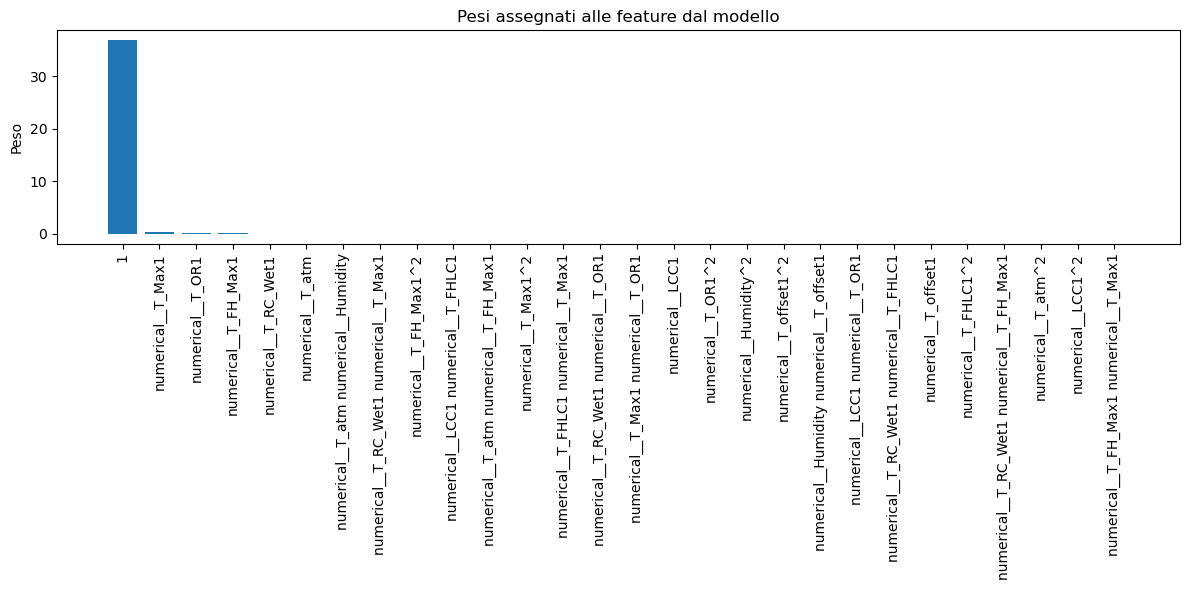

In [38]:
plot_feature_weights(prlsf_grid_search.best_estimator_)

Il peso dell’intercetta ("1") è chiaramente su una scala molto diversa rispetto a quello delle altre feature: rappresenta il valore medio di partenza della predizione e non ha un significato comparabile ai pesi delle variabili esplicative. Per questo motivo, è opportuno escluderla dalla visualizzazione dei pesi delle feature, così da rendere il grafico più leggibile e interpretare correttamente l’importanza relativa delle variabili nel modello.

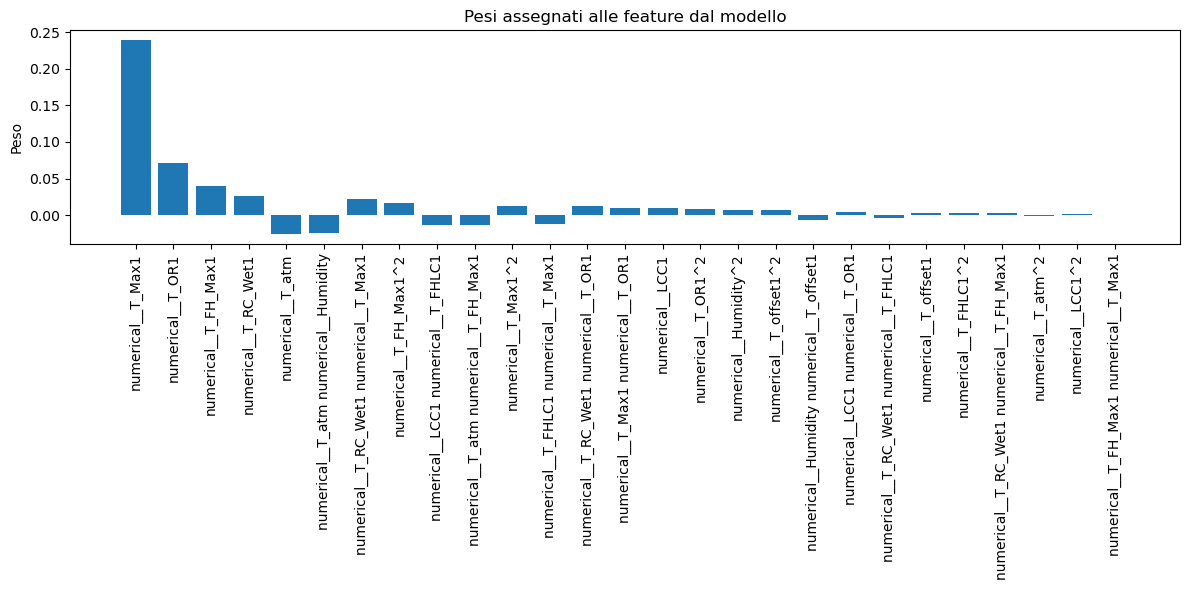

In [39]:
plot_feature_weights(prlsf_grid_search.best_estimator_, exclude_intercept=True)

Questo modello rappresenta il miglior risultato ottenuto finora, con un netto miglioramento rispetto agli approcci precedenti. Nonostante siano state mantenute più feature rispetto al Lasso puro, quasi tutte presentano pesi regolari e interpretabili, e solo poche variabili correlate alla temperatura orale hanno coefficienti negativi. Questo indica che la selezione preventiva delle feature più importanti attraverso Lasso e la successiva regolarizzazione ElasticNet hanno efficacemente ridotto l’instabilità dovuta alla multicollinearità, nonostante si sia realizzata una regressione polinomiale.

## 2 - Principal Component Regression (PCR)

La Principal Component Analysis (PCA) è una tecnica di riduzione della dimensionalità che trasforma un insieme di variabili correlate in un nuovo insieme di variabili non correlate, chiamate **componenti principali**. Queste componenti sono ordinate in modo che la prima spieghi la massima varianza possibile nei dati, la seconda la massima varianza residua, e così via. 

La PCA è strettamente collegata alla decomposizione ai valori singolari (SVD), che abbiamo incontrato nel contesto dei sistemi di raccomandazione. In entrambi i casi, l’obiettivo è ridurre la dimensionalità dei dati trovando una rappresentazione compatta che preservi la maggior parte dell’informazione.

In particolare, applicare la PCA a una matrice di dati centrata (cioè con media zero) equivale, dal punto di vista computazionale, a eseguire la SVD di quella matrice.

Infatti, le componenti principali della PCA corrispondono alle colonne di $V$ nella SVD. Se selezioniamo solo le prime $k$ componenti (cioè quelle associate ai $k$ valori singolari più grandi), otteniamo una rappresentazione ridotta dei dati che conserva la maggior parte dell'informazione originale, riducendo al contempo rumore e ridondanza.

In questo approccio, applichiamo la PCA **esclusivamente** alle variabili che rappresentano le misure di temperatura facciale, mantenendo invece separate le altre feature numeriche (come temperatura ambientale, umidità, distanza, ecc.) e le variabili categoriche. In questo modo, riduciamo la dimensionalità e la collinearità solo delle variabili termiche, che sono quelle più numerose e fortemente correlate tra loro, senza perdere l'informazione fornita dalle altre feature. Infine applichiamo una trasformazione polinomiale sulle componenti estratte.

Il risultato è una pipeline in cui:
- Le feature di temperatura facciale vengono trasformate in un numero ridotto di componenti principali tramite PCA, e poi riaumentate attraverso trasformazione polinomiale.
- Le altre variabili numeriche vengono standardizzate ma non ridotte.
- Le variabili categoriche vengono codificate tramite one-hot encoding.


In [40]:
# Pipeline per temperature_features: StandardScaler -> PCA -> PolynomialFeatures
temp_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures(include_bias=False))
])

# Le colonne che non sottoponiamo a PCA
other_numeric_features = [col for col in numerical_columns if col not in temperature_features]

pcr_elasticnet_preprocessor = ColumnTransformer(
    transformers=[
        ('temp_pca', temp_pca_pipeline, temperature_features),
        ('other_num', StandardScaler(), other_numeric_features),
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ]
)

pcr_elasticnet_model = Pipeline([
    ('preprocessor', pcr_elasticnet_preprocessor),
    ('regressor', Lasso())
])

# Grid di ricerca: numero componenti PCA, alpha e l1_ratio ElasticNet
pcr_elasticnet_grid = {
    'preprocessor__temp_pca__poly__degree': [1,2,3,4],
    'preprocessor__temp_pca__pca__n_components': np.arange(2,15),
    'regressor__alpha': np.logspace(-2, 1, 10),
}

pcr_elasticnet_grid_search = GridSearchCV(
    pcr_elasticnet_model,
    pcr_elasticnet_grid,
    cv=kf_5,
    n_jobs=-1,
    verbose=2
)

pcr_elasticnet_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 520 candidates, totalling 2600 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('temp_pca',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['Max1R13_1',
                                                                          'Max1L13_1',
                                                                          'aveAllR13_1',
                                                                          'aveAllL13_1',
                                                                          'T_RC1',
                                                                          'T_RC_Dry1',
                                                                          'T_RC_Wet1',
                                                                          'T_RC_Ma...
                                                                                                    '51-60',
                                                                                                    '>60']],
                                                                                       drop='first'),
                                                                         ['Gender',
                                                                          'Age'])])),
                                       ('regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'preprocessor__temp_pca__pca__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'preprocessor__temp_pca__poly__degree': [1, 2, 3, 4],
                         'regressor__alpha': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])},
             verbose=2)

R^2: 0.7043
R^2 aggiustato: 0.6719
RMSE: 0.2426
MAE: 0.1822
MAPE: 0.49%


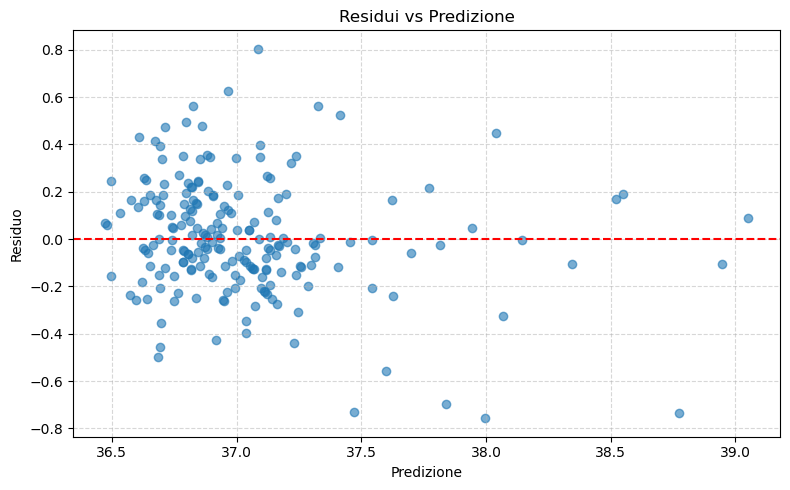

In [41]:
results['pcr_elasticnet'] = evaluate_regression_model(pcr_elasticnet_grid_search.best_estimator_, X_val, y_val)

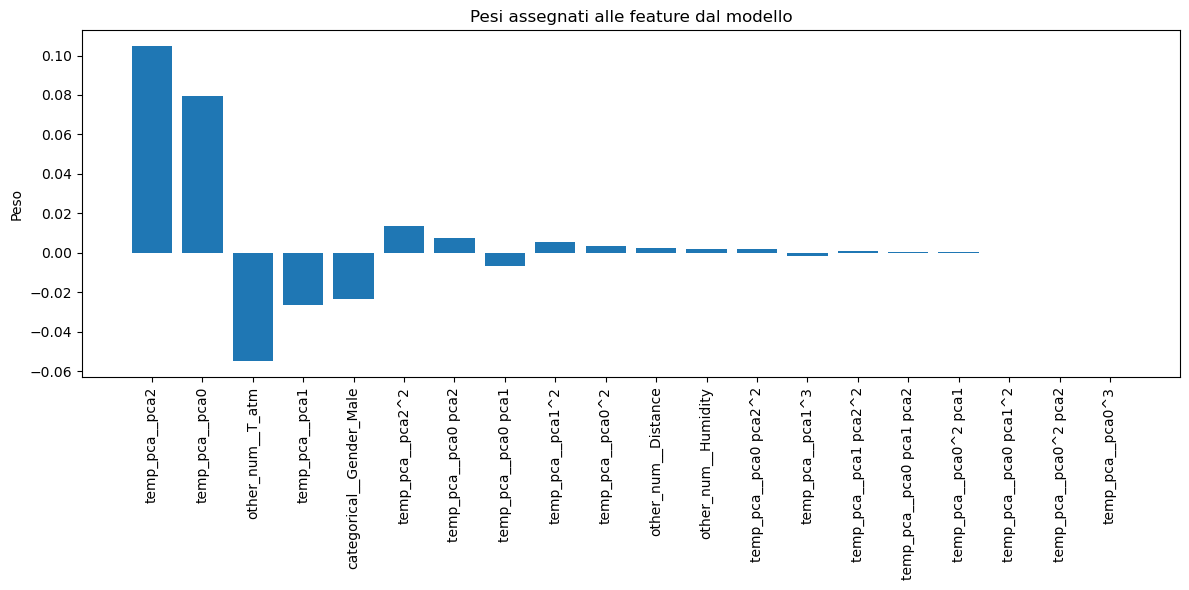

In [42]:
plot_feature_weights(pcr_elasticnet_grid_search.best_estimator_)

Il risultato ottenuto attraverso questo metodo non è male, ma nemmeno particolarmente impressionante. In particolare, l’utilizzo della PCA rende le feature risultanti difficilmente interpretabili dal punto di vista pratico, poiché rappresentano combinazioni lineari delle variabili originali. 

## 3 - Regressione con alberi gradient boosting

In [43]:
xgb_preprocessor = ColumnTransformer(
    transformers=[
        (NUM, StandardScaler(), numerical_columns),
        (CAT, OneHotEncoder(categories=categorical_values, drop='first'), categorical_columns)
    ]
)

xgb_model = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', XGBRegressor(random_state=RANDOM_STATE))
])

xgb_grid = {
    'regressor__n_estimators': [100, 200, 400, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
}

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_grid,
    cv=kf_5,
    n_jobs=10,
    verbose=2
)

xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['T_atm',
                                                                          'Humidity',
                                                                          'Distance',
                                                                          'T_offset1',
                                                                          'Max1R13_1',
                                                                          'Max1L13_1',
                                                                          'aveAllR13_1',
                                                                          'aveAllL13_1',
                                                                          'T_RC1',
                                                                          'T_RC_Dry1',
                                                                          'T_RC_Wet1',
                                                                          'T_RC_Max1',
                                                                          'T_LC1',
                                                                          'T_LC_Dry1',
                                                                          'T_LC_Wet1',
                                                                          'T_LC_Max1',...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=10,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [100, 200, 400, 500],
                         'regressor__subsample': [0.8, 1.0]},
             verbose=2)

Impossibile determinare il numero di feature con peso diverso da zero.
Assumiamo che tutte le feature siano utilizzate.
R^2: 0.7036
R^2 aggiustato: 0.6481
RMSE: 0.2428
MAE: 0.1836
MAPE: 0.49%


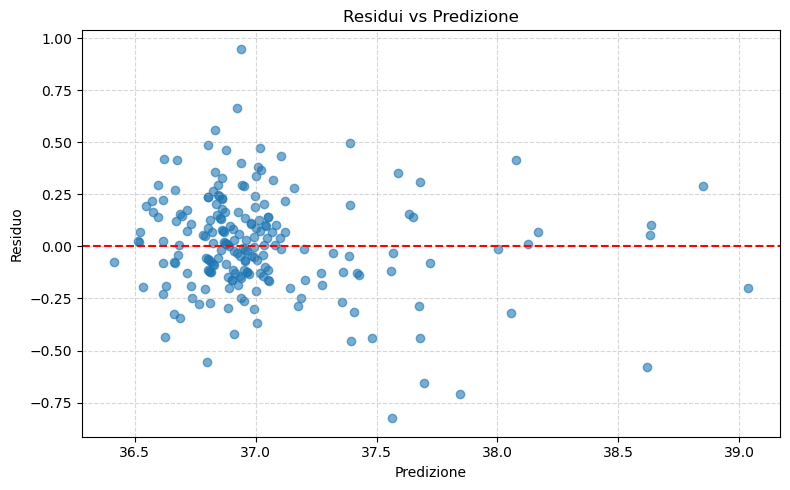

In [44]:
results['xgb_model'] = evaluate_regression_model(xgb_grid_search.best_estimator_, X_val, y_val)

Il risultato ottenuto con XGBoost è buono: le sue performance sono comparabili a quelle ottenute attraverso la PCR, ma un vantaggio importante è che XGBoost non ha richiesto particolari sforzi implementativi o di selezione manuale delle feature. Tuttavia, il modello utilizza tutte le variabili disponibili, il che penalizza l’$R^2$ aggiustato e rende il modello poco interpretabile. 

# Conclusione

In [45]:
def plot_results_histograms(results):
    """
    Visualizza un istogramma per ciascuna metrica di valutazione dei modelli.
    Ogni barra rappresenta un modello sull'asse delle x.
    L'asse y è adattato per enfatizzare le differenze tra i modelli.
    """

    results_df = pd.DataFrame(results).T  # Modelli come righe

    metrics = results_df.columns.tolist()
    n_metrics = len(metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))

    if n_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        values = results_df[metric]
        min_val = values.min()
        max_val = values.max()
        # Calcoliamo un margine del 5% del range
        margin = (max_val - min_val) * 0.05 if max_val != min_val else 0.1 * abs(max_val)

        axs[i].bar(results_df.index, values, color='skyblue')
        axs[i].set_title(metric, loc='center')
        axs[i].set_xlabel('Modello', loc='center')
        axs[i].set_ylabel(metric)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].set_xticks(range(len(results_df.index)))
        axs[i].set_xticklabels(results_df.index, ha='center')
        # Impostiamo i limiti dell'asse y per enfatizzare le differenze
        axs[i].set_ylim(min_val - margin, max_val + margin)

    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()

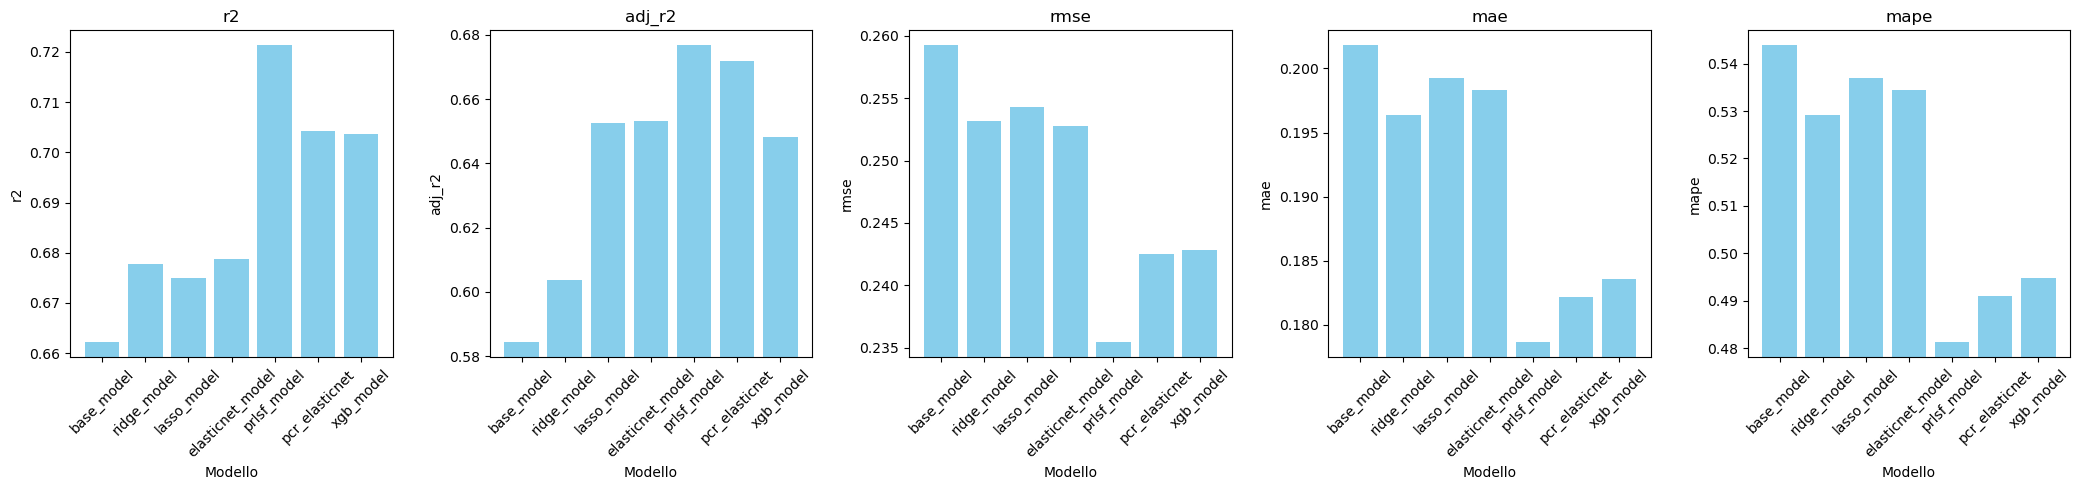

In [46]:
plot_results_histograms(results)

Vediamo come si sono comportati i vari modelli:

- **Baseline (Linear Regression):** Il modello lineare semplice fornisce già un risultato accettabile, ma soffre di instabilità dovuta alla multicollinearità tra le feature.

- **Regolarizzazione (Ridge, Lasso, ElasticNet):** Ridge ottiene un leggero miglioramento rispetto al modello base, ma resta inferiore a Lasso ed ElasticNet. Questo perché la regolarizzazione L2 (Ridge) tende a ridurre i pesi delle feature collineari senza azzerarli, lasciando comunque parte dell'instabilità dovuta alla multicollinearità. Lasso (L1) e ElasticNet (L1+L2) invece selezionano automaticamente le feature più informative, eliminando quelle ridondanti e migliorando la stabilità e la generalizzazione del modello.

- **Selezione Feature + Regressione Polinomiale (prlsf_model):** Questo approccio, che combina selezione automatica delle feature, espansione polinomiale e regolarizzazione, è il più efficace. Dimostra che una selezione mirata delle variabili e l’introduzione di non linearità migliorano sensibilmente la capacità predittiva.

- **Principal Component Regression (PCR):** La riduzione della dimensionalità tramite PCA aiuta a gestire la collinearità, ma non supera la combinazione di selezione feature + polinomi. L'aggiunta di feature polinomiali in seguito alla selezione delle feature si conferma positiva per le performance del modello.

- **XGBoost:** Il modello ad alberi gradient boosting si comporta bene, quasi quanto il modello con principal component analisis (se non contiamo adj_r2). Questo conferma come i modelli ad alberi, come XGBoost, siano meno sensibili alla collinearità tra le feature rispetto ai modelli lineari, riuscendo a gestire variabili fortemente correlate senza generare instabilità nei pesi o perdita di performance, grazie alla loro struttura gerarchica e alla selezione automatica delle variabili più informative durante la costruzione degli split.

In conclusione, per questo dataset la soluzione migliore da noi individuata è una pipeline che seleziona le feature più informative, applica una trasformazione polinomiale e utilizza una regolarizzazione forte (ElasticNet con parametro L1 = 1, equivalente a Lasso). I modelli ad alberi sono una valida alternativa, soprattutto se si desidera evitare la selezione manuale delle feature. Anche la Principal Component Analisis si è rivelata un buon approccio, ma non sembra essere la migliore per rapporto tra sofisticazione e performance.

## PS: Limiti e possibili miglioramenti

Ci siamo chiesti se la presenza di gruppi demografici poco rappresentati avrebbe potuto introdurre un under-representation bias nei risultati dei modelli. Come è possibile vedere dall’analisi delle performance sui diversi gruppi, questo fenomeno si è effettivamente verificato: i modelli tendono a performare peggio sulle categorie meno numerose.

Un possibile miglioramento sarebbe quello di affrontare in modo esplicito il problema della scarsa rappresentatività di alcuni gruppi demografici, ad esempio tramite tecniche di bilanciamento dei dati (come oversampling o pesatura delle classi) o valutando le performance dei modelli con metriche specifiche per ciascun gruppo. 

### PRLSF

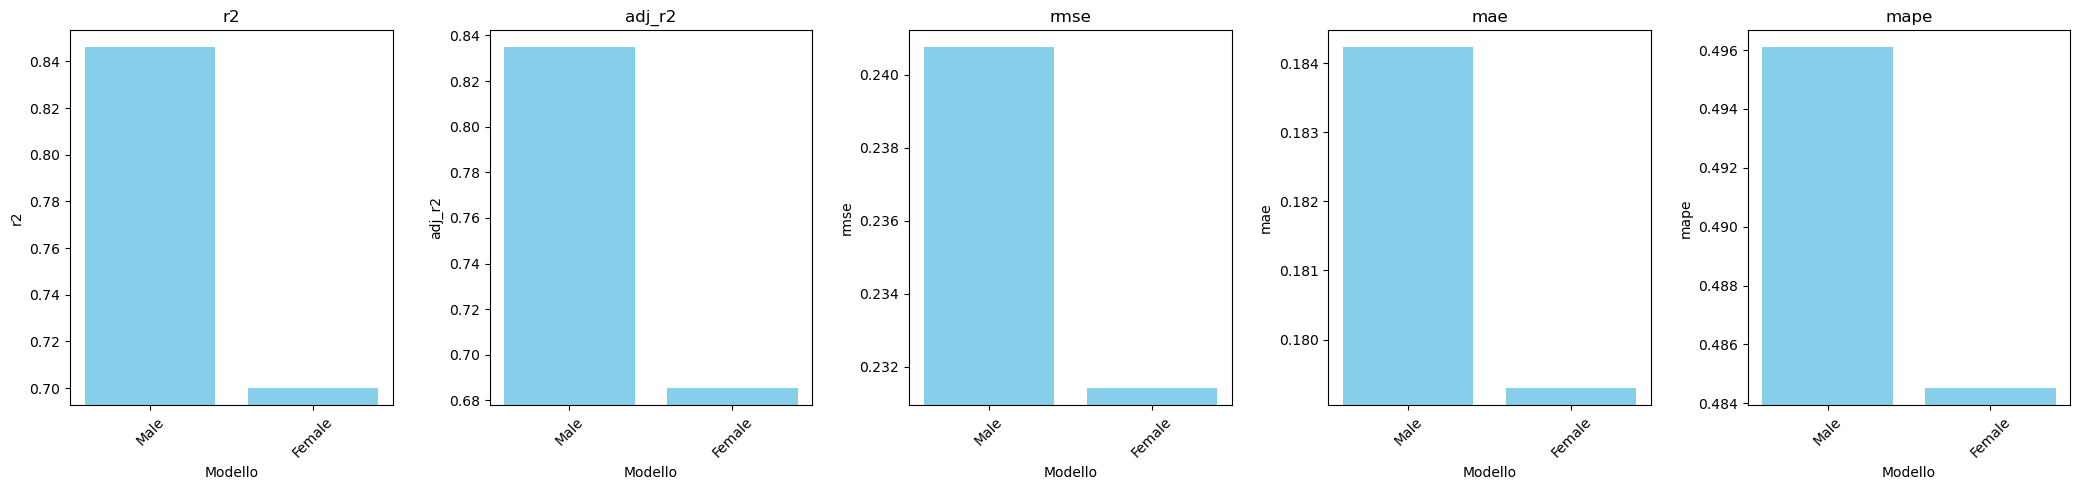

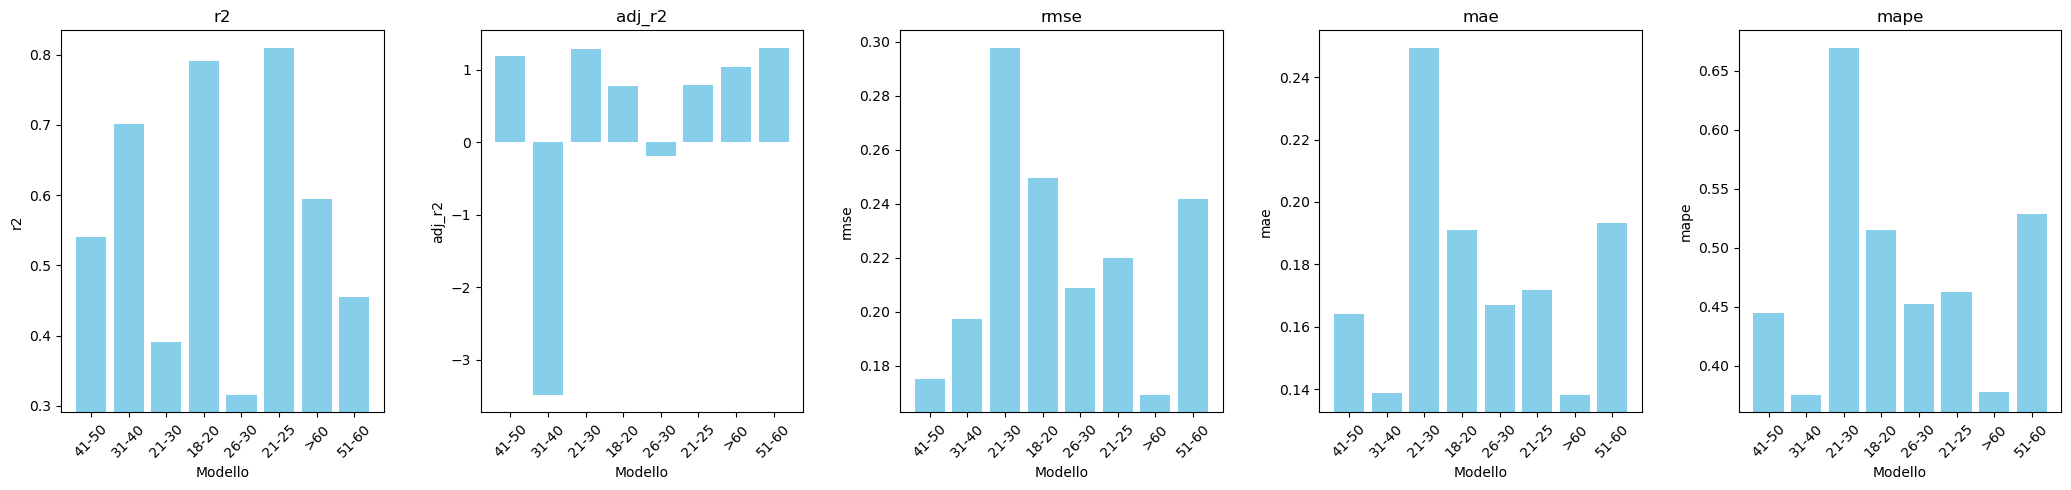

In [47]:
# Funzione che valuta un modello di regressione sulle diverse categorie di un gruppo
def evaluate_on_groups(model, X_val, y_val, group_col):
    groups = X_val[group_col].unique()
    results = {}
    for group in groups:
        idx = X_val[group_col] == group
        X_group = X_val[idx]
        y_group = y_val[idx]
        results[group] = evaluate_regression_model(model, X_group, y_group, print_results=False)
    return results

plot_results_histograms(evaluate_on_groups(prlsf_grid_search.best_estimator_, X, y, 'Gender'))
plot_results_histograms(evaluate_on_groups(prlsf_grid_search.best_estimator_, X, y, 'Age'))

### PCR

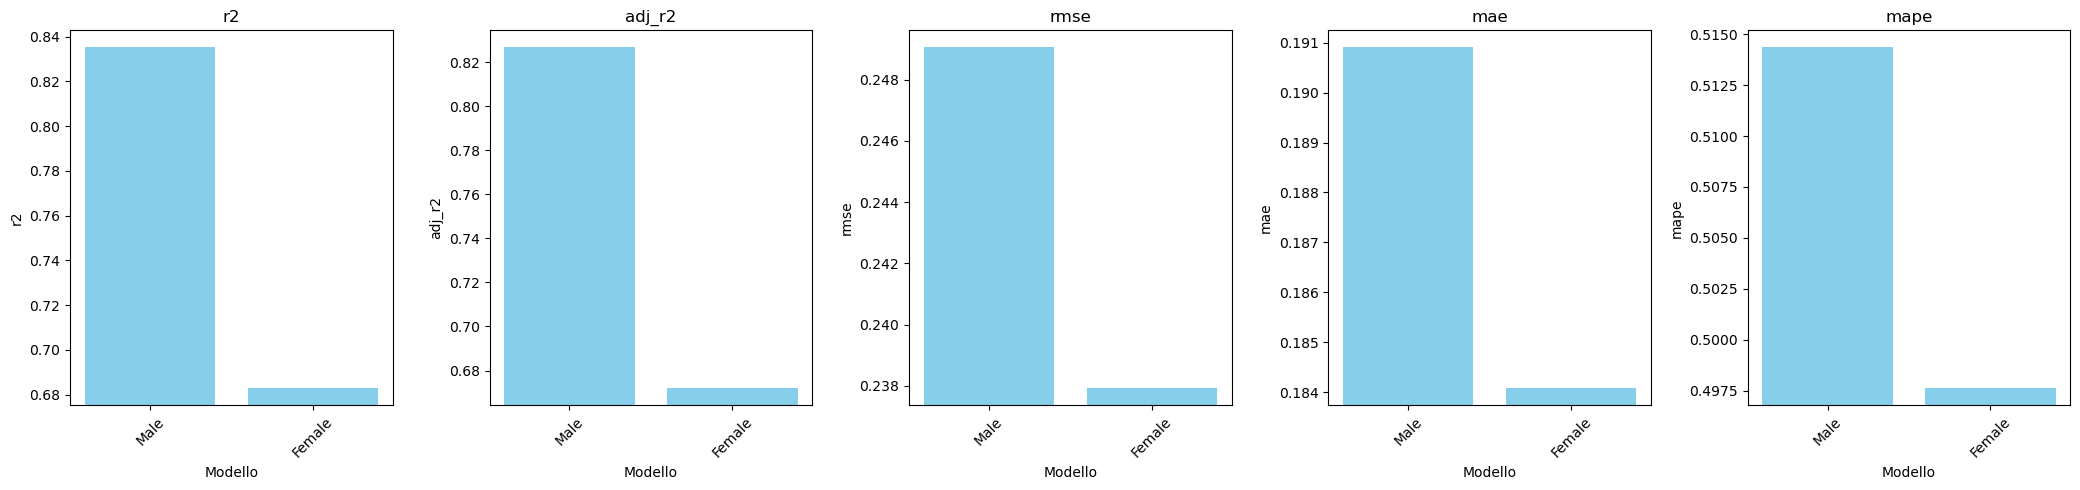

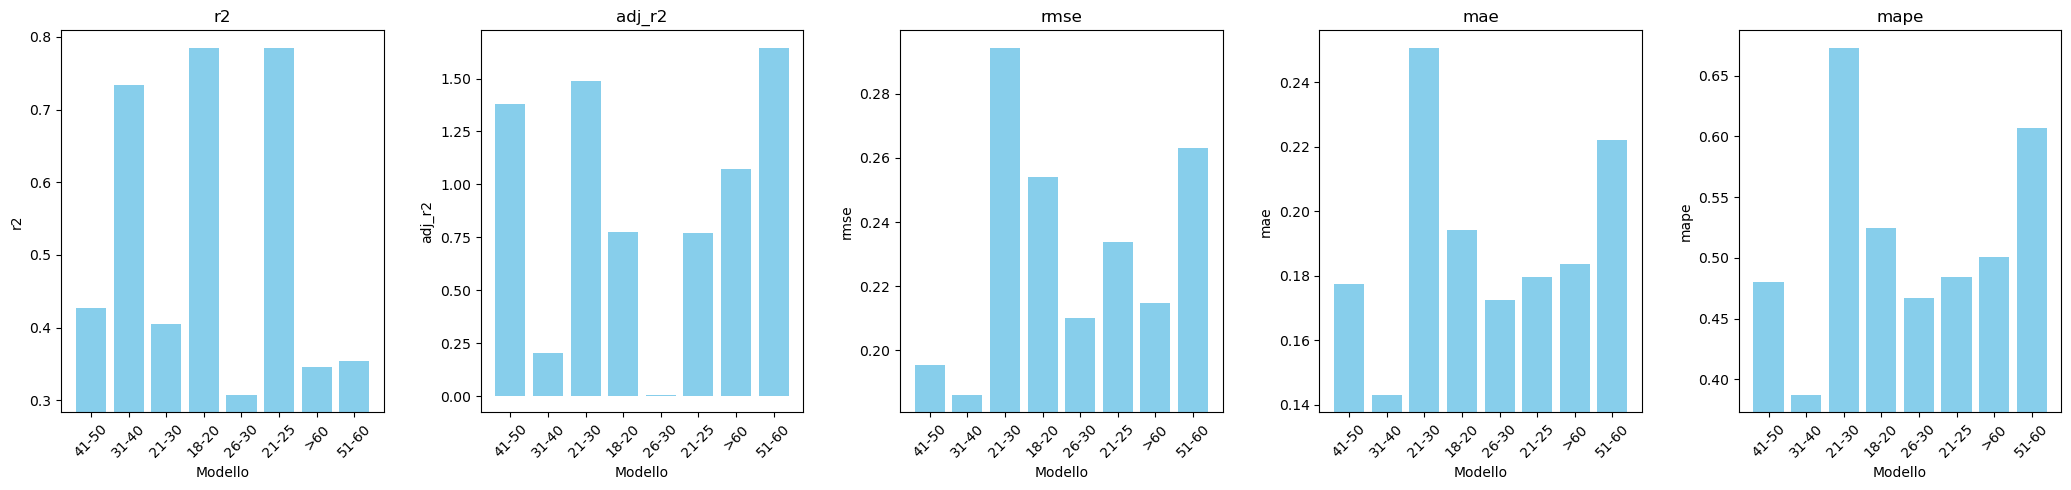

In [48]:
plot_results_histograms(evaluate_on_groups(pcr_elasticnet_grid_search.best_estimator_, X, y, 'Gender'))
plot_results_histograms(evaluate_on_groups(pcr_elasticnet_grid_search.best_estimator_, X, y, 'Age'))

### XGBoost

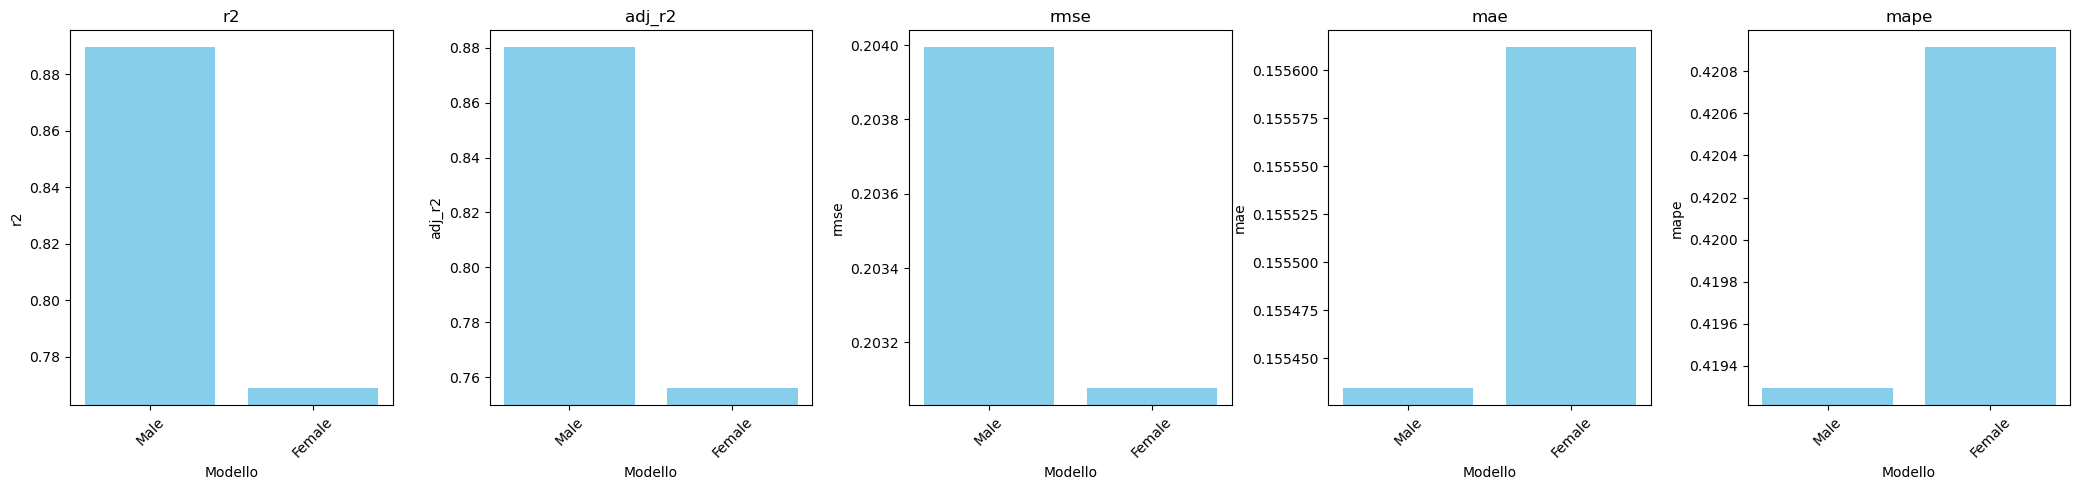

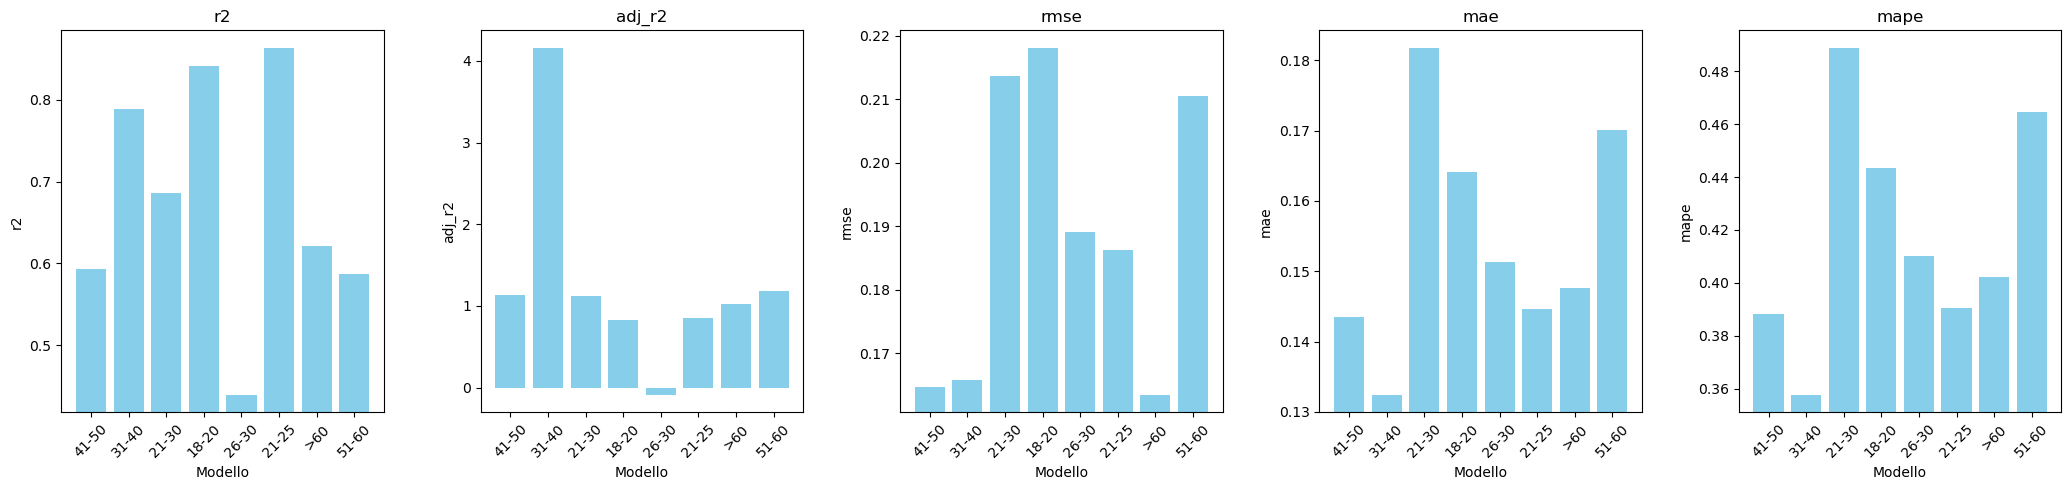

In [49]:
plot_results_histograms(evaluate_on_groups(xgb_grid_search.best_estimator_, X, y, 'Gender'))
plot_results_histograms(evaluate_on_groups(xgb_grid_search.best_estimator_, X, y, 'Age'))